In [1]:
import os
import pywt
import torch
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from quantus.metrics import Complexity
from scipy.fftpack import fft, fftfreq
from torch.utils.data import DataLoader, TensorDataset

from src.models.simple import SimpleCNN
from src.attribution import compute_attribution
from src.evaluation.evaluation import evaluate_attributions


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)                          # Python built-in random
    np.random.seed(seed)                       # NumPy random
    torch.manual_seed(seed)                    # CPU random seed
    torch.cuda.manual_seed(seed)               # GPU random seed (if used)
    torch.cuda.manual_seed_all(seed)           # All GPUs (if multiple GPUs)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Optional: for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
# set seed
set_seed(42)

# to mps if available otherwise to cpu
device = torch.device('mps' if torch.backends.mps.is_available()  else 'cpu')
print(f"Using device: {device}")

# load the model
model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# load the model weights
model.load_state_dict(torch.load("./model/checkpoint/simpleCNN_4.pth", map_location=torch.device('mps')))
model.to(device)

Using device: mps


SimpleCNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 2, kernel_size=(5,), stride=(1,))
    (4): AdaptiveAvgPool1d(output_size=1)
    (5): Flatten(start_dim=1, end_dim=-1)
  )
)

In [4]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/train_4"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(50000, 1, 1000)
(50000,)


In [5]:
def plot_fft(signal, fs):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title("FFT")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

Number of batches: 391
Batch shape 2, sample and label
Sample batch size 128
Label batch size 128 tensor([1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1])
Sample shape torch.Size([128, 1, 1000])
Label shape torch.Size([128])


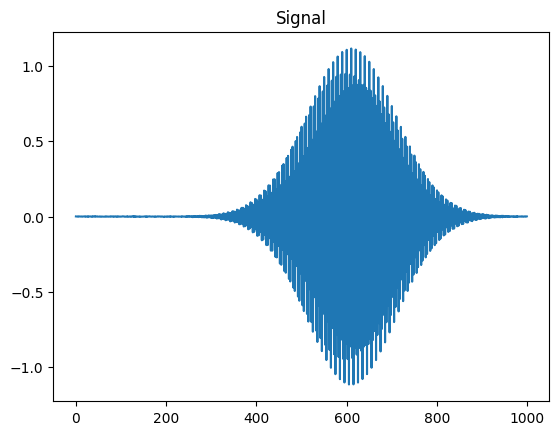

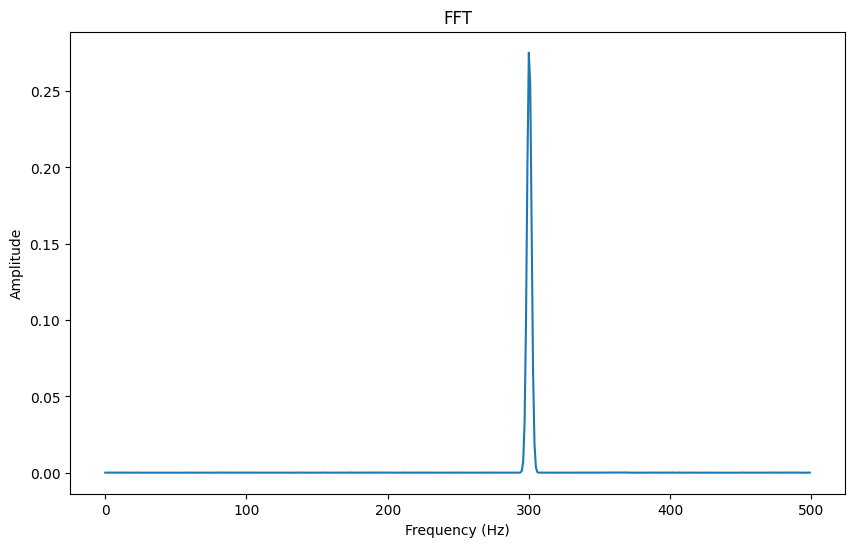

In [6]:
print(f"Number of batches: {len(test_loader)}")
for batch in test_loader:
    print(f"Batch shape {len(batch)}, sample and label")
    x, y = batch
    print(f"Sample batch size {len(x)}")
    print(f"Label batch size {len(y)} {y}")
    print(f"Sample shape {x.shape}")
    print(f"Label shape {y.shape}")

    signal = x[0][0].detach().cpu().numpy()
    plt.figure()
    plt.plot(signal)
    plt.title("Signal")
    plt.show()

    plot_fft(signal, 1000)
    break

Number of batches: 79
Batch shape 2, sample and label
Sample batch size 128
Label batch size 128 tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1])
Sample shape torch.Size([128, 1, 1000])
Label shape torch.Size([128])


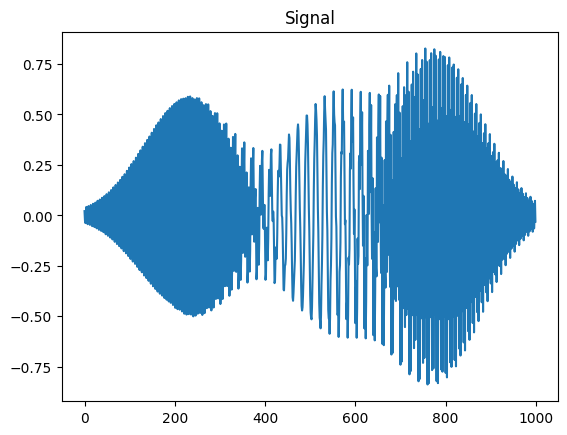

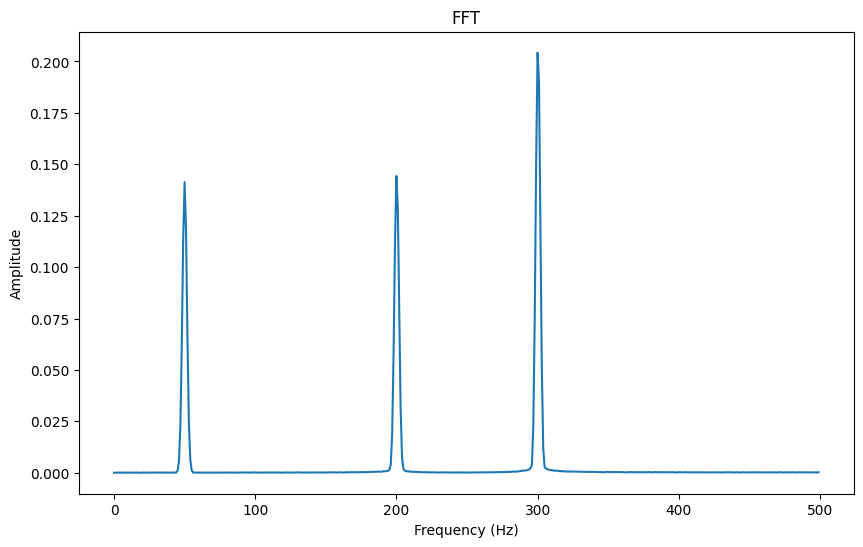

In [188]:
print(f"Number of batches: {len(test_loader_5)}")
for batch_5 in test_loader_5:
    print(f"Batch shape {len(batch_5)}, sample and label")
    x_5, y_5 = batch_5
    print(f"Sample batch size {len(x_5)}")
    print(f"Label batch size {len(y_5)} {y_5}")
    print(f"Sample shape {x_5.shape}")
    print(f"Label shape {y_5.shape}")

    signal = x_5[0][0].detach().cpu().numpy()
    plt.figure()
    plt.plot(signal)
    plt.title("Signal")
    plt.show()

    plot_fft(signal, 1000)
    break

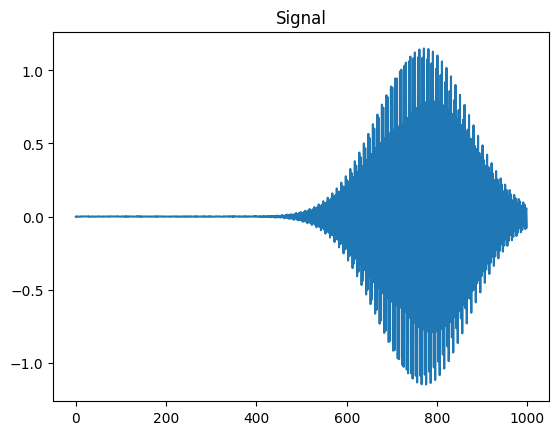

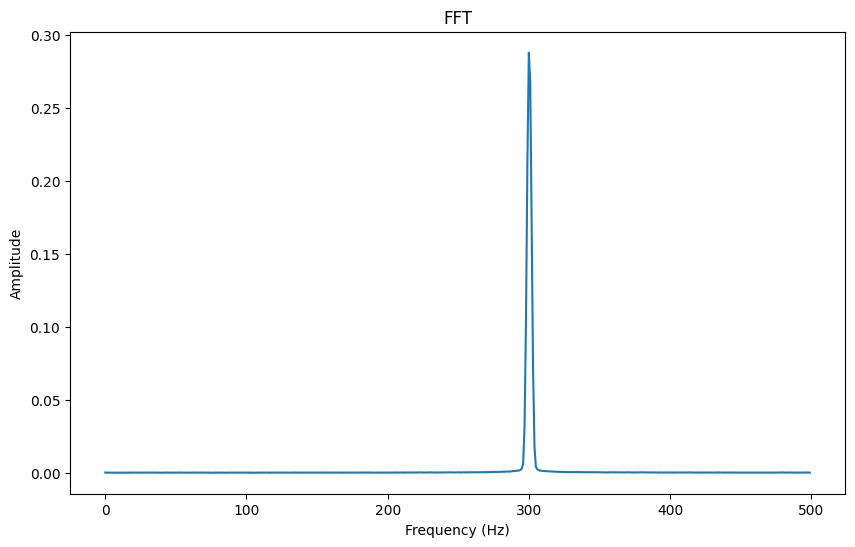

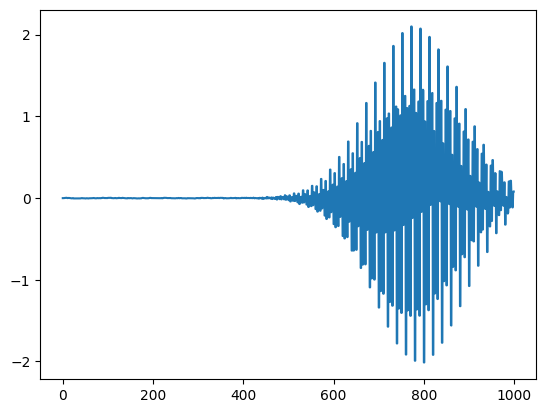

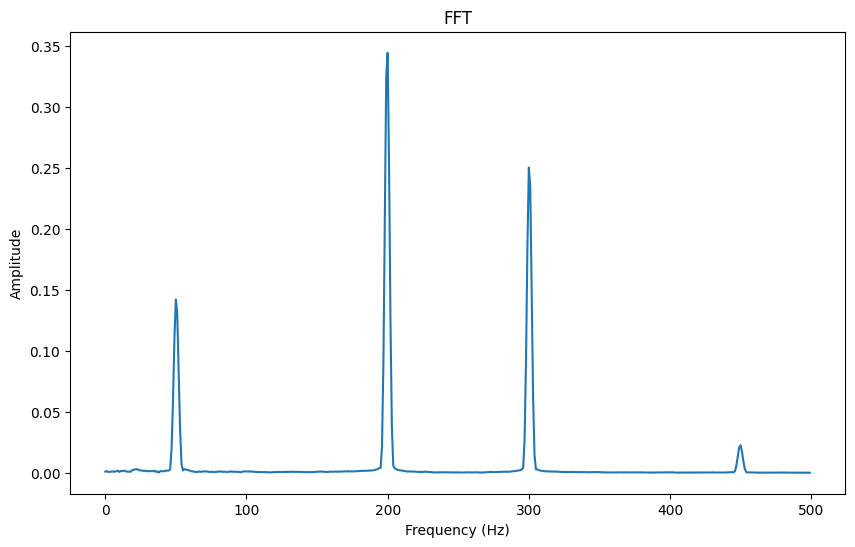

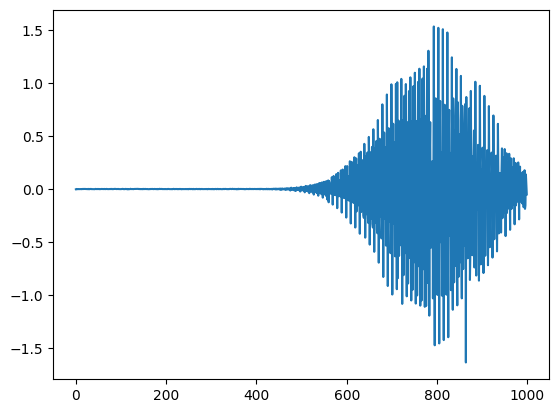

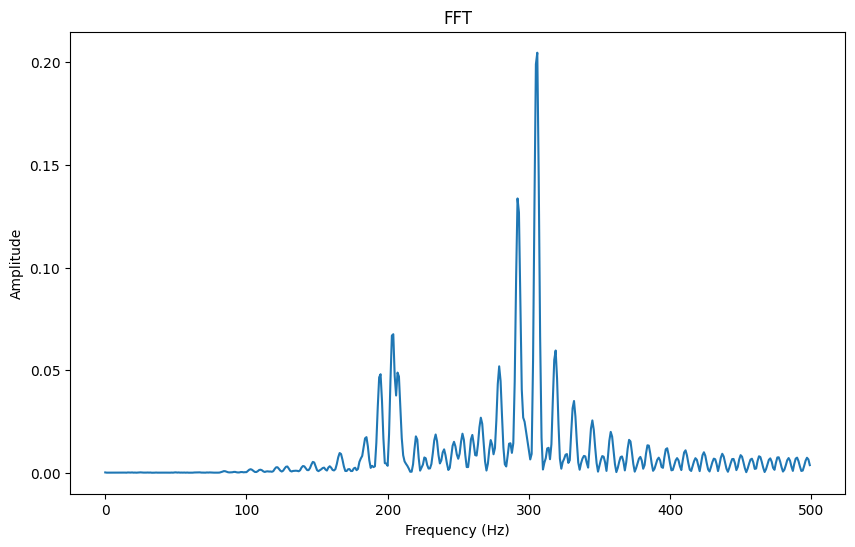

In [8]:
from src.utils.sampling import upsampling_wavedec, downsample_wavedec


# given a signal
coeffs = pywt.wavedec(signal, 'coif5')

plt.plot(signal)
plt.title("Signal")
plt.show()

plot_fft(signal, 1000)

# upsample to have the same length
upsampled_coeffs = upsampling_wavedec(len(signal), coeffs)
downsampled_coeffs = downsample_wavedec(len(signal), upsampled_coeffs, 'coif5', 5)

d = pywt.waverec(downsampled_coeffs, 'coif5')

# add over the levels and plot the resulting signal
s = np.sum(upsampled_coeffs, axis=0)
plt.plot(s)
plt.show()

plot_fft(s, 1000)

# d = np.sum(s, axis=0)
plt.plot(d)
plt.show()

plot_fft(d, 1000)



In [36]:
import torch.nn.functional as F

attributions = {}
attributions['deletion'] = {}
attributions['insertion'] = {}
predictions = []
labels = []

predictions_5 = []
labels_5 = []

print('TEST 4')

# prediction
for i, batch in enumerate(test_loader):
    # get data
    x, y = batch
    x = x.to(device)
    output = model(x)

    # Apply softmax to get probabilities
    probabilities = F.softmax(output, dim=1)

    # If you want to see the probabilities for a specific sample (e.g., first sample)
    sample_probabilities = probabilities[0]  # For batch size > 1
    print("Class probabilities:", sample_probabilities)

    # To get the predicted class (highest probability)
    predicted_class = torch.argmax(sample_probabilities)
    print("Predicted class:", predicted_class.item())

    predictions.append(output)
    labels.append(y)

    if i == 20:
        break

# concatenat the predictions and the labels through the first dim
predictions = torch.cat(predictions, dim=0)
labels = torch.cat(labels, dim=0)

print('TEST 5')

for j, batch_5 in enumerate(test_loader_5):
    # get data
    x_5, y_5 = batch_5
    x_5 = x_5.to(device)
    output_5 = model(x_5)

    # Apply softmax to get probabilities
    probabilities_5 = F.softmax(output_5, dim=1)

    # If you want to see the probabilities for a specific sample (e.g., first sample)
    sample_probabilities_5 = probabilities_5[0]  # For batch size > 1
    print("Class probabilities:", sample_probabilities_5)

    # To get the predicted class (highest probability)
    predicted_class_5 = torch.argmax(sample_probabilities_5)
    print("Predicted class:", predicted_class_5.item())

    predictions_5.append(output_5)
    labels_5.append(y_5)

    if j == 20:
        break

# concatenat the predictions and the labels through the first dim
predictions_5 = torch.cat(predictions_5, dim=0)
labels_5 = torch.cat(labels_5, dim=0)

TEST 4
Class probabilities: tensor([1.4470e-11, 1.0000e+00], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 1
Class probabilities: tensor([1.5672e-09, 1.0000e+00], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 1
Class probabilities: tensor([1.0000e+00, 1.7613e-08], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 0
Class probabilities: tensor([1.2526e-10, 1.0000e+00], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 1
Class probabilities: tensor([5.6057e-11, 1.0000e+00], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 1
Class probabilities: tensor([1.0000e+00, 3.2390e-08], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 0
Class probabilities: tensor([1.0000e+00, 3.5151e-07], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 0
Class probabilities: tensor([9.6647e-08, 1.0000e+00], device='mps:0', grad_fn=<SelectBackward0>)
Predicted class: 1
Class probabilities: tensor([8.7097e-11, 1.0000e+00], device='mps

In [11]:
print(predictions.shape)
print(predictions[0])
print(labels.shape)

print(predictions[0])

torch.Size([10000, 2])
tensor([-12.4768,  12.4821], device='mps:0', grad_fn=<SelectBackward0>)
torch.Size([10000])
tensor([-12.4768,  12.4821], device='mps:0', grad_fn=<SelectBackward0>)


In [8]:
correct = 0
for i in range(len(predictions)):
    if predictions[i].argmax() == labels[i]:
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")

Accuracy: 1.0


In [9]:
# save it in the attributions dict
attributions['predictions'] = predictions
attributions['labels'] = labels

In [10]:
# evaluate wavelet
fs = 16
batch_size = 128
wavelet = 'db'
w_len = 1
level = pywt.dwt_max_level(fs, 'db1')
key_ = f'wavelet_{wavelet}{w_len}_{level}_{batch_size}'
print(key_)

wavelet_db1_4_128


In [12]:
# set the seed for reproducibility
set_seed(42)

# compute the attributions
method = 'wavelet'

args = SimpleNamespace(wavelet=wavelet, len_w=w_len, level=level, sample_freq=fs)
print(args.wavelet)
print(args.len_w)
print(args.level)
print(args.sample_freq)

attrs, masks = compute_attribution(method = method, model = model, test_loader= test_loader, args = args, device=device, normalize=True)

db
1
4
16
Batch 0 of 79
Sample 0 of 128
Epoch 0: Loss=1.3615, Target=1.2715, Reg=0.0900
Epoch 10: Loss=0.4598, Target=0.4184, Reg=0.0414
Epoch 20: Loss=0.3874, Target=0.3326, Reg=0.0548
Epoch 30: Loss=0.3756, Target=0.3222, Reg=0.0534
Epoch 40: Loss=0.3664, Target=0.3200, Reg=0.0464
Epoch 50: Loss=0.3589, Target=0.3195, Reg=0.0394
Epoch 60: Loss=0.3540, Target=0.3196, Reg=0.0345
Epoch 70: Loss=0.3507, Target=0.3197, Reg=0.0311
Epoch 80: Loss=0.3488, Target=0.3197, Reg=0.0291
Epoch 90: Loss=0.3467, Target=0.3197, Reg=0.0270
Epoch 100: Loss=0.3444, Target=0.3196, Reg=0.0248
Epoch 110: Loss=0.3425, Target=0.3194, Reg=0.0231
Epoch 120: Loss=0.3410, Target=0.3192, Reg=0.0219
Epoch 130: Loss=0.3395, Target=0.3190, Reg=0.0206
Epoch 140: Loss=0.3385, Target=0.3188, Reg=0.0197
Epoch 150: Loss=0.3376, Target=0.3188, Reg=0.0188
Epoch 160: Loss=0.3368, Target=0.3186, Reg=0.0182
Epoch 170: Loss=0.3361, Target=0.3184, Reg=0.0176
Epoch 180: Loss=0.3356, Target=0.3182, Reg=0.0173
Epoch 190: Loss=0.335

In [13]:
attributions[key_] = attrs
attributions[f'filtermasks_{key_}'] = masks

In [14]:
print(attributions.keys())
print(key_)
print(len(attributions[key_]))
print(len(attrs[0]))
print(len(masks))
print(len(test_loader))

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])
wavelet_db1_4_128
1
128
1
79


In [ ]:
# # read data
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_1_0.1.pkl'

# with open(path, 'rb') as f:
#     attributions = pickle.load(f)
# print(f"Attributions loaded from {path}")

Attributions loaded from public/simple/wavelet_db1_4_128_results_1_0.1.pkl


In [15]:
# print the type of attributions[key_]
print(type(attributions[key_]))

temporal = 'insertion'
print(type(attributions[temporal]))

# check if the dictionary is empty
print(len(attributions['insertion']))

<class 'list'>
<class 'dict'>
0


In [16]:
print(type(attributions[key_]))
print(len(attributions[key_]))
print(len(attributions[key_][0]))
print(len(attributions[key_][0][0]))
print(len(attributions[key_][0][0][0]))
print(len(attributions[key_][0][0][0][0]))

<class 'list'>
1
128
1
16
5


In [17]:
key_2 = f'filtermasks_{key_}'
print(type(attributions[key_2]))
print(len(attributions[key_2]))
print(len(attributions[key_2][0]))
print(len(attributions[key_2][0][0]))
print(len(attributions[key_2][0][0][0]))

<class 'list'>
1
128
16
5


In [18]:
# plot scaleograms

def plot_dwt_scaleogram(coeffs, w='db1', fs=16, label=0):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs[0]))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order
    
    scaleogram = np.array(coeffs)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, 1, fs)
    time = np.concatenate([time, [time[-1] + (1/fs)]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram.T, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of class {label} of wavelet {w}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [ ]:
import pywt
import torch
import math
import numpy as np
import torch.nn.functional as F

from src.utils.sampling import upsampling_wavedec, downsample_wavedec, split_string

def evaluate_attributions_test(model, 
                          loader, 
                          attribution, 
                          quantiles, 
                          mode = 'insertion', 
                          domain = 'fft',
                          wavelet = 'db1', 
                          device = 'cpu'):
    
    model.eval().to(device)

    if domain == 'wavelet':
        wavelet_name, filter_length = split_string(wavelet)
        filter_length = int(filter_length)

    with torch.no_grad():
        accuracies = []
        mean_true_class_probs = []
        ce_losses = []
        for quantile in quantiles:
            correct = 0
            total = 0
            ce_loss = 0
            mean_true_class_prob = 0

            print(f"Quantile: {quantile}")

            for i, batch in enumerate(loader):
                # do just the last batch
                if i != len(loader) - 1:
                    continue

                # assuming the batch is a tuple of samples and true labels
                x, y = batch
                # assuming the time dimension is the last dimension
                time_dim = -1
                time_len = len(x[0][0])

                if domain == 'wavelet':
                    # assuming one channel
                    wavelet_transform = []
                    coeffs = pywt.wavedec(x, wavelet)

                    for j in range(len(coeffs)):  # iterate over levels
                        level_list = []
                        for k in range(len(coeffs[j])):  # batch size
                            batch_list = []
                            for l in range(len(coeffs[j][k])):  # channels
                                signal = coeffs[j][k][l]
                                factor = math.ceil(time_len / len(signal))
                                upsampled = np.repeat(signal, factor)[:time_len]
                                batch_list.append(upsampled)
                            level_list.append(batch_list)
                        wavelet_transform.append(level_list)

                    wavelet_transform = np.moveaxis(np.array(wavelet_transform), 0, -1)
                    data = torch.tensor(wavelet_transform).float().to(device)

                    print(f"Data shape: {data.shape}")
                    plot_dwt_scaleogram(data.detach().cpu().numpy()[0][0])

                shape = data.shape
                    
                print(f"Attribution shape: {attribution[i].shape}")
                imp = attribution[i].reshape(shape).to(torch.float32).to(device)
                plot_dwt_scaleogram(imp.detach().cpu().numpy()[0][0])

                # flatten data and compute quantile
                flattened_imp = imp.reshape(shape[0], -1)
                k = int(quantile * flattened_imp.size(1))

                # find top k indices
                _, indices = torch.topk(flattened_imp, k=k, dim=1)

                # create mask
                mask = torch.zeros_like(flattened_imp, dtype=torch.int)
                mask.scatter_(1, indices, True)
                mask = mask.view(shape).to(device)
                print(f"Mask shape: {mask.shape}")
                # print(mask.detach().cpu().numpy()[0][0])
                # conver the boolean values into 0 1

                plot_dwt_scaleogram(mask.detach().cpu().numpy()[0][0])

                # apply mask to data
                if mode == 'insertion':
                    masked_data = data * mask
                elif mode == 'deletion':
                    masked_data = data * (~mask)

                else:
                    raise ValueError("mode must be 'insertion' or 'deletion'")

                print(f"Masked data shape: {masked_data.shape}")
                plot_dwt_scaleogram(masked_data.detach().cpu().numpy()[0][0])
                
                if domain == 'wavelet':
                    # downsample the data to the original size
                    masked_data_np = masked_data.detach().cpu().numpy()
                    # print(f"Masked data shape numpy: {masked_data_np.shape}")

                    masked_data_np = np.moveaxis(masked_data_np, -2, -1)  # now shape: [batch_size, channels, levels, time]
                    # print(f"Masked data shape numpy after move axis: {masked_data_np.shape}")

                    reconstructed_data = []

                    for j in range(masked_data_np.shape[0]):  # over batch
                        for k in range(masked_data_np.shape[1]):  # over channels
                            coeffs = downsample_wavedec(time_len, masked_data_np[j][k], wavelet_name, filter_length)  # should be a flat list of np arrays
                            recon = pywt.waverec(coeffs, wavelet)
                            reconstructed_data.append(recon)

                    data = torch.tensor(np.array(reconstructed_data)).float().to(device)


                output = model(data.float()).detach().cpu()

                _, predicted = torch.max(output, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                ce_loss += F.cross_entropy(output, y).item()/len(batch)
                mean_true_class_prob += torch.take_along_dim(F.softmax(output, dim=1), y.unsqueeze(1), dim = 1).sum().item()

                break

            accuracies.append(correct / total)
            ce_losses.append(ce_loss)
            mean_true_class_probs.append(mean_true_class_prob / total)

        return accuracies, mean_true_class_probs, ce_losses

In [20]:
set_seed(42)

# compute accuracy scores
quantiles = np.arange(0, 1.05, 0.05)
for mode in ['deletion', 'insertion']:
    if not mode in attributions.keys():
        attributions[mode] = {}
    
    acc_scores = evaluate_attributions(model, test_loader, attributions[key_], quantiles=quantiles, mode=mode, device=device, domain='wavelet', wavelet='db1')
    attributions[mode][key_] = acc_scores

Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Attribution shape: torch.Size([128, 1, 16, 5])
Data shape: torch.Size([128, 1, 16, 5])
Att

In [ ]:
print(attributions.keys())

dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'wavelet_db1_4_128', 'filtermasks_wavelet_db1_4_128'])


In [22]:
set_seed(42)

# stores the accuracy, mean true class prob and cross-entropy loss throughout the quantiles
for k in attributions['insertion'].keys():
    print(k)
    print(len(attributions['insertion'][k]))
    print(len(attributions['insertion'][k][0]))
    for val in range(len(attributions['insertion'][k])):
        print(attributions['insertion'][k][val])

wavelet_db1_4_128
3
21
[0.4765625, 0.8984375, 0.8984375, 0.9296875, 0.9453125, 0.9453125, 0.953125, 0.953125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.4785326421260834, 0.894485354423523, 0.8968337178230286, 0.921108603477478, 0.9422693848609924, 0.9447525143623352, 0.9496507048606873, 0.9510709047317505, 0.9942281246185303, 0.9939899444580078, 0.9926794767379761, 0.9996933937072754, 0.9999913573265076, 0.9999985098838806, 0.999998927116394, 0.999998927116394, 0.999998927116394, 0.999998927116394, 0.999998927116394, 0.999998927116394, 0.9999991059303284]
[0.8397212624549866, 0.16094906628131866, 0.14581595361232758, 0.1182951033115387, 0.10112766176462173, 0.08961512893438339, 0.08541136234998703, 0.08465985208749771, 0.0032538275700062513, 0.0034405714832246304, 0.004348453599959612, 0.00015620516205672175, 4.3186846596654505e-06, 7.352737156907097e-07, 5.499425697053084e-07, 5.294536435940245e-07, 5.247971444077848e-07, 5.247971444077848e-07, 5.238658218331

In [23]:
complexities = {}
grad_complexties = {}
comp = Complexity()

In [24]:
set_seed(42)
# for att in attributions:
#     if att == 'insertion':
#         print(attributions['insertion'].keys())
    
# for key in attributions['insertion'].keys():
key = 'wavelet_db1_4_128'
if not key in complexities.keys():
    print('first')
    complexities[key] = []
    grad_complexties[key] = []

scores = []
grad_scores = []

for i in range(len(attributions[key])):
    expl = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    expl = expl.to(dtype=torch.float32).numpy()
    
    ex = np.maximum(attributions[key][i].numpy(), 0)
    if 'filterbank' in key:
        ex = np.transpose(ex, (0, 2, 1))

    # min max normalize
    ex_min = np.min(ex, axis = -1, keepdims=True)
    ex_max = np.max(ex, axis = -1, keepdims=True)
    ex = (ex - ex_min) / (ex_max - ex_min + 1e-10)
    # ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True) + 1e-10)
    expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
    expl_grad = np.reshape(expl_grad, (attributions[key][i].shape[0], -1))

    expl = np.maximum(expl, 0)
    # check if all expl values are zero
    if np.all(expl == 0):
        print("All zeros")
        # add a small epsilon to avoid division by zero
        expl = np.ones_like(expl) * 1e-10

    # to compute complexities it has to be a numpy float32 otherwise err
    complexity = comp.evaluate_batch(expl, expl)
    complexity = np.nan_to_num(complexity)
    expl_grad = np.nan_to_num(expl_grad)
    scores += complexity.tolist()
    grad_scores += list(expl_grad)

complexities[key].append(np.mean(scores))
grad_complexties[key].append(np.mean(grad_scores))

print(complexities)
print(grad_complexties)

first
{'wavelet_db1_4_128': [np.float64(1.353330739374008)]}
{'wavelet_db1_4_128': [np.float32(0.84400916)]}


In [11]:
# load the data from a file

folder = 'public/simple/'
path = f'{folder}flextime_128.pkl'

with open(path, 'rb') as f:
    attributions = pickle.load(f)
print(f"Attributions loaded from {path}")


print(attributions.keys())
print(attributions['insertion']['flextime_128'])
print(attributions['complexities']['flextime_128'])



Attributions loaded from public/simple/flextime_128.pkl
dict_keys(['deletion', 'insertion', 'predictions', 'labels', 'flextime_128', 'filtermasks_flextime_128', 'complexities', 'grad_complexities'])
([0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.4999999750137329, 0.9985762157440186, 0.9985814811706543, 0.9986091856002808, 0.9999990041732788, 0.9999990034103393, 0.9999990034103393, 0.9999990018844604, 0.9999989995956421, 0.9999989965438842, 0.999998992729187, 0.9999989919662475, 0.9999989919662475, 0.9999989904403687, 0.999998985862732, 0.9999989835739136, 0.9999989828109741, 0.9999989828109741, 0.9999989828109741, 0.9999989812850952, 0.9999989812850952], [113.2812670469284, 0.056157451414037496, 0.05594978865701705, 0.05485815741121769, 3.9987669197216746e-05, 4.0011417723917475e-05, 4.0036097743723076e-05, 4.009244278790902e-05, 4.0148321971855694e-05, 4.020792638925741e-05, 4.0283828951714895e-05, 4.036625088588153e-05, 

In [65]:
# import pickle

# # dump to file
# folder = 'public/simple/'
# path = f'{folder}{key_}_results_1_0.1.pkl'

# with open(path, 'wb') as f:
#     pickle.dump(attributions, f)
# print(f"Saved to {path}")

Saved to public/simple/filtermasks_wavelet_db1_4_128_results_1_0.1.pkl


In [25]:
def plot_scaleogram_wav_heatmap(signal, attribution, prediction:int, label:int, fs=1000 ):
    # print(attribution.shape)

    # Compute frequency bands
    freq_bands = [fs /  (2 ** (j + 1)) for j in range(len(attribution[0]))]   # bands
    freq_bands.append(0)                                        # lowest frequency
    freq_bands = freq_bands[::-1]                               # reverse the order
    # print(freq_bands)

    time = np.linspace(0, signal / fs, signal)
    

    # normalize attribution scores to [0,1]
    attribution = np.abs(attribution)
    attr_norm = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-10)

    # Create a 2D grid for heatmap
    time_grid, freq_grid = np.meshgrid(time, freq_bands)
    # make attr x one dim smaller
    attr_norm = attr_norm[1:,:]

    # Plot the scaleogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time_grid, freq_grid, attr_norm.T, shading='auto', cmap='Greens')
    plt.colorbar(label="Normalized Attribution Score")
    plt.title(f'Attributions of class {label} learned through wavelet db1')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.show()

In [26]:
samples_0 = []
samples_1 = []

# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()
    y = y.numpy()

    for i in range(len(x)):
        if y[i] == 0:
            samples_0.append(x[i][0])
        else:
            samples_1.append(x[i][0])

    break

print(len(samples_0))
print(len(samples_1))



61
67


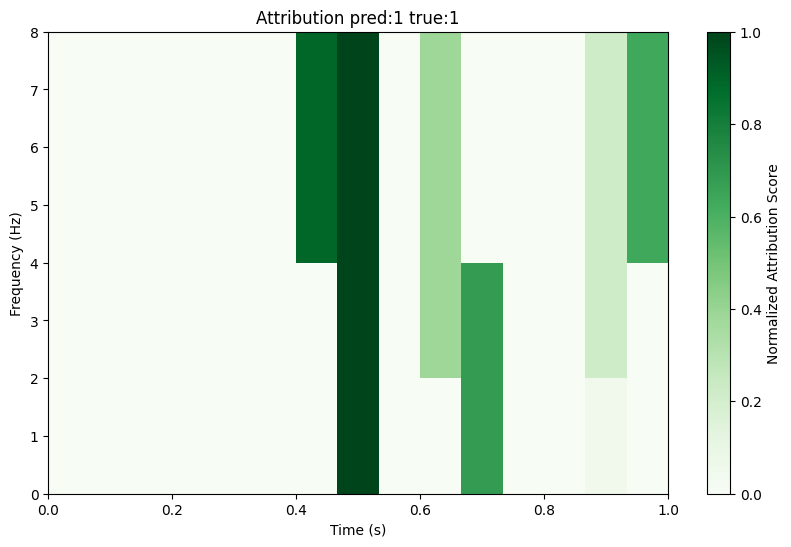

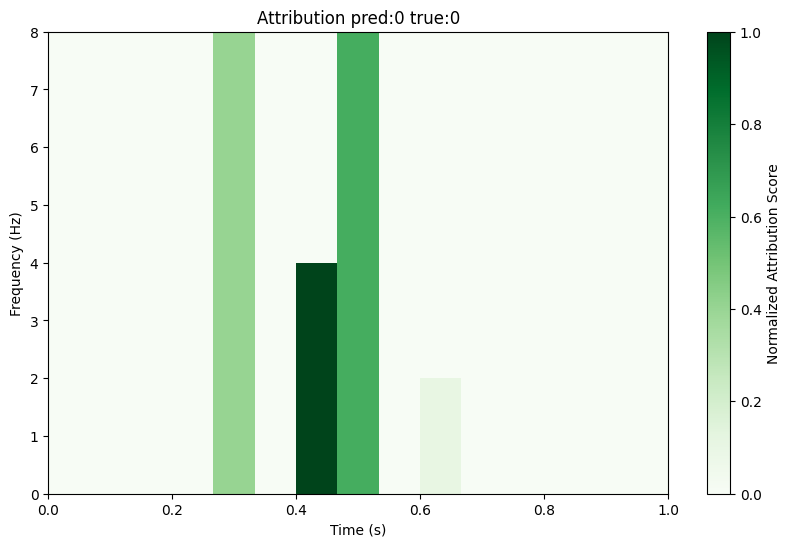

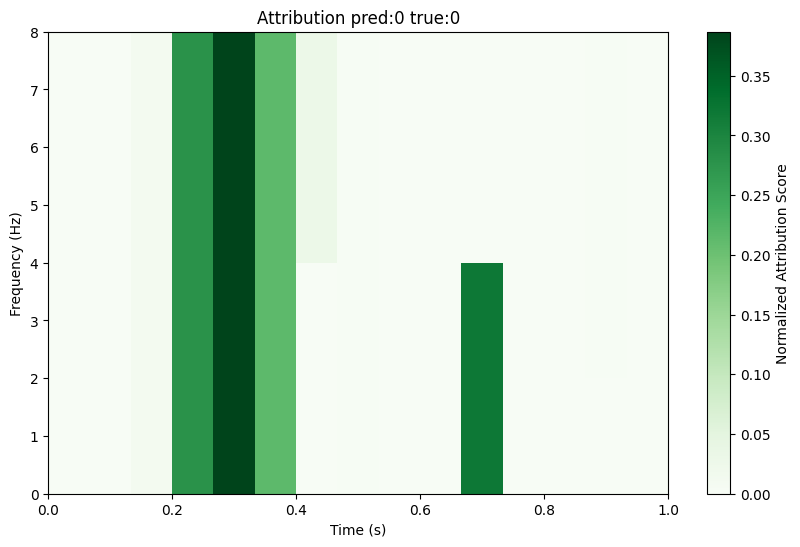

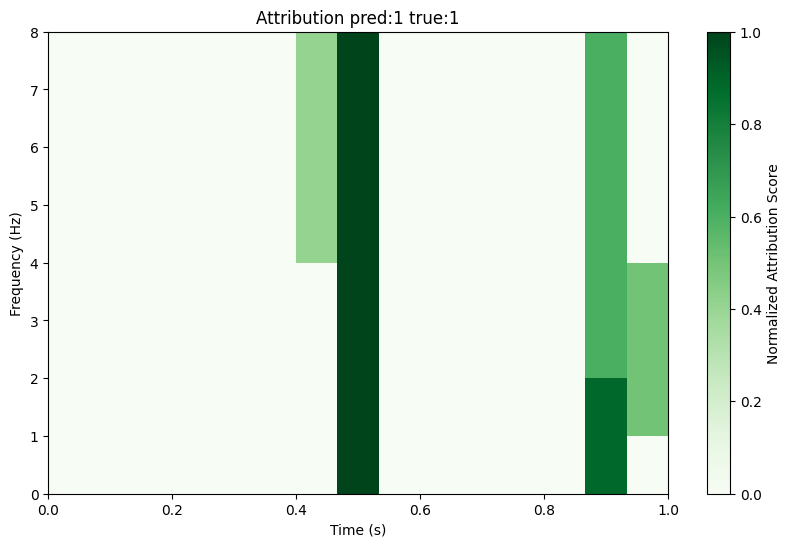

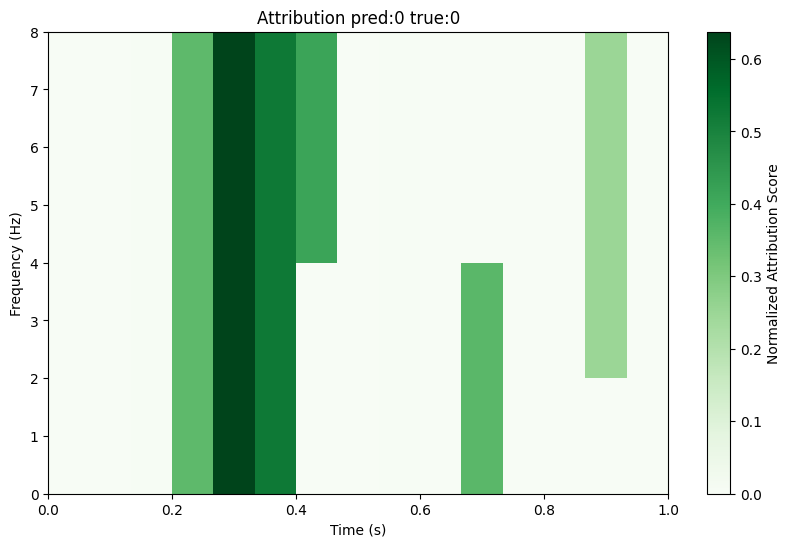

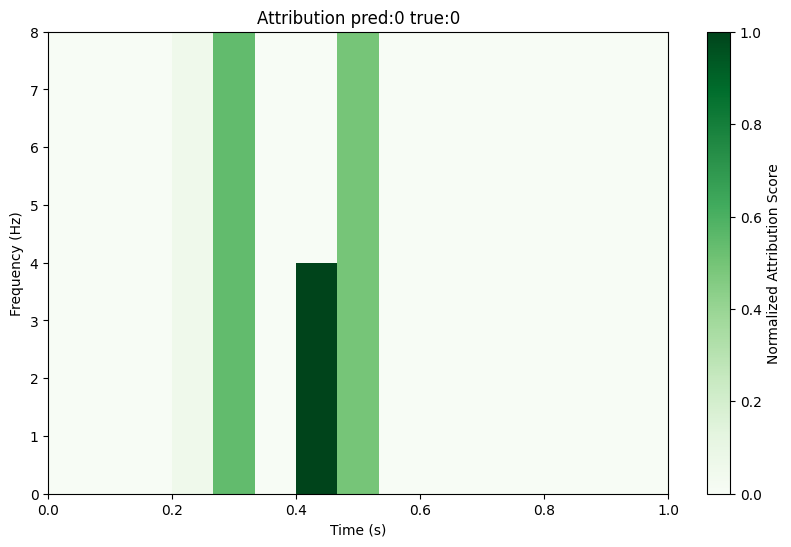

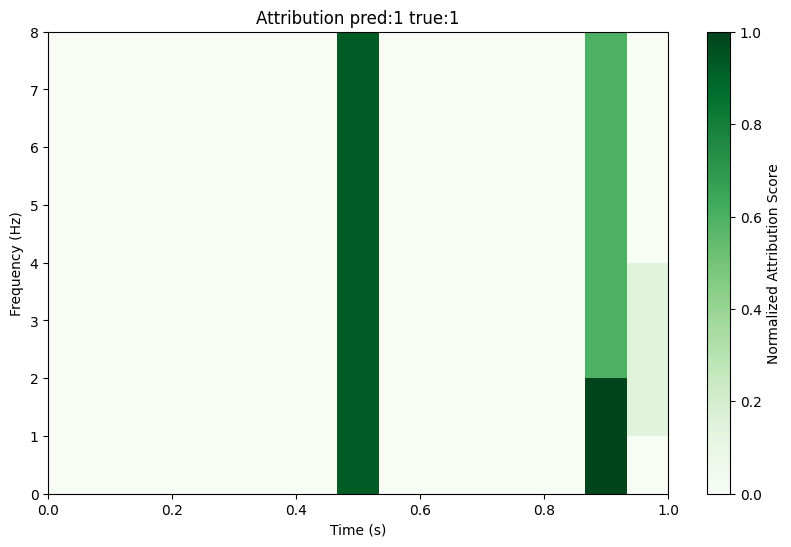

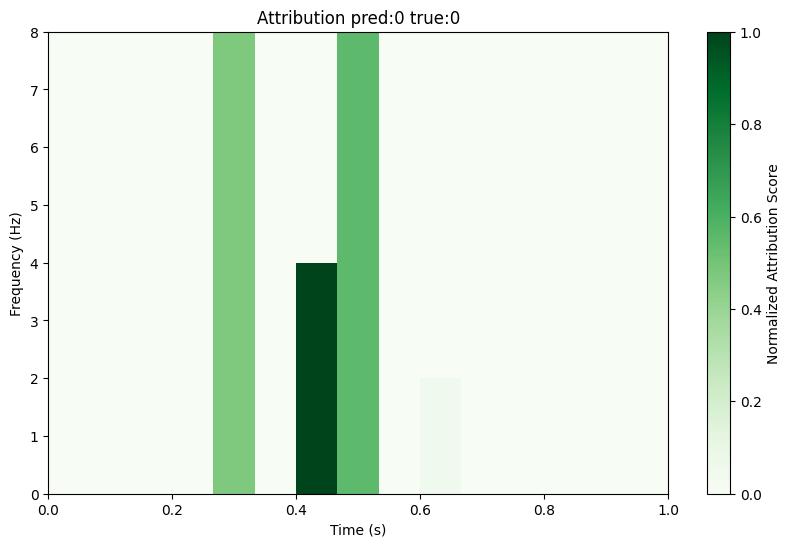

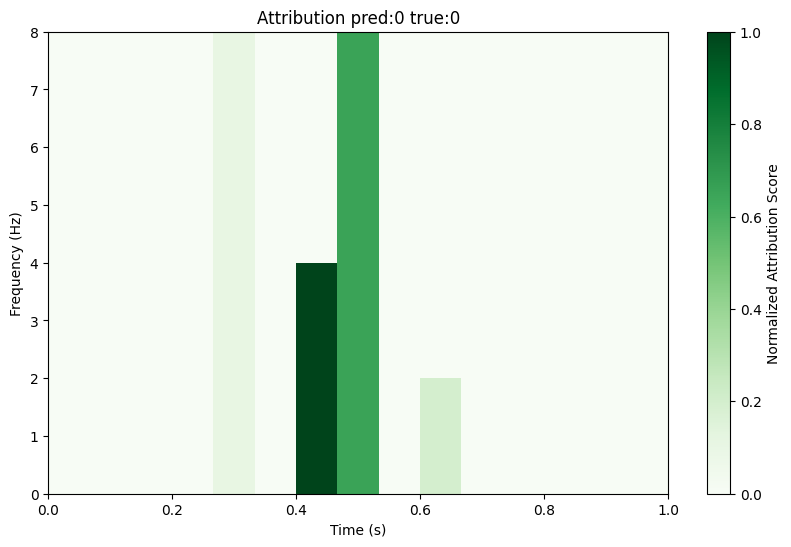

In [59]:
# plot the scores as a heatmap on the original signal
max_level = pywt.dwt_max_level(16, 'db1')

# plot 5 samples
for i in range(1, 10):
    plot_scaleogram_wav_heatmap(len(x[i][0]), attributions['filtermasks_wavelet_db1_4_128'][0][i], prediction=attributions['predictions'][i].argmax(), label=attributions['labels'][i], fs=fs, level=max_level)


wavelet_db1_4_128


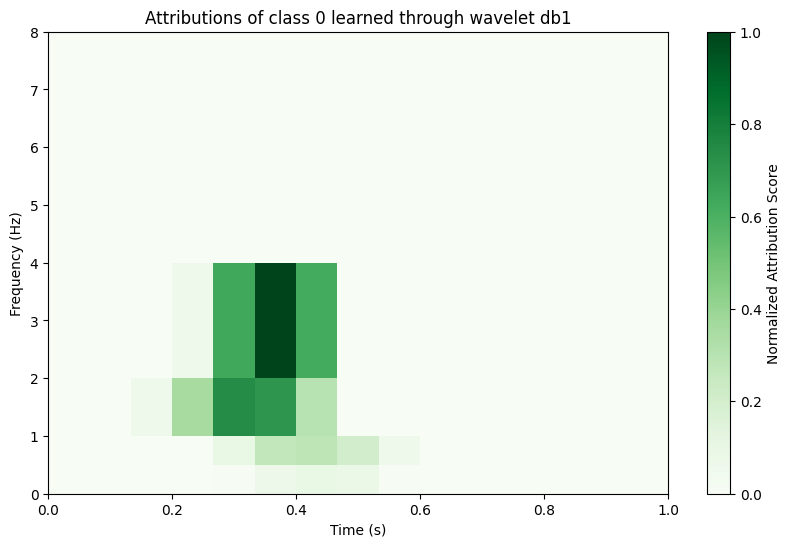

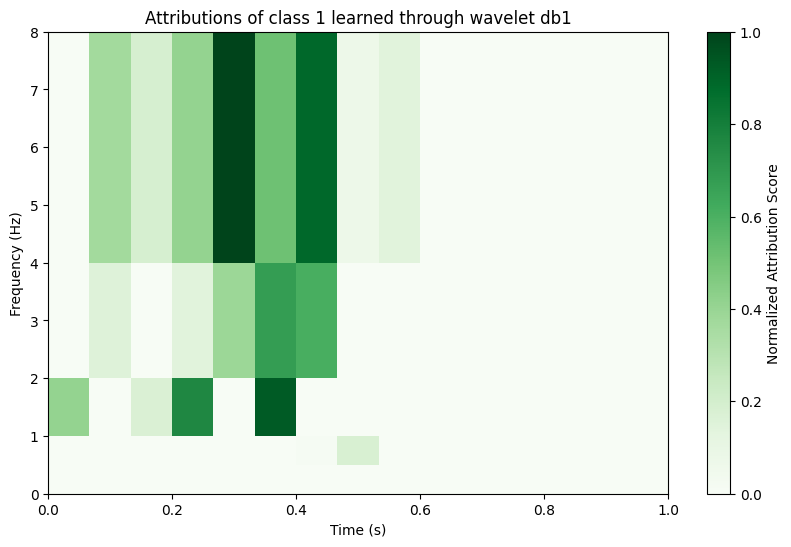

Counts of label 0: 61, label 1: 67
Shape of mask 0: (16, 5), mask 1: (16, 5)


In [30]:
counts_0 = 0
counts_1 = 0

# attributions['insertion']['wavelet_db1_4_128'] = scores

set_seed(42)

for key in attributions['insertion'].keys():
    print(key)

    method, wavelet, max_level, batch_size = key.split('_')
    max_level = int(max_level)

    masks_0 = np.zeros_like(masks[0][0])
    masks_1 = np.zeros_like(masks[0][0])

    index = 0

    for i, batch in enumerate(test_loader):
        x, y = batch

        for j in range(len(masks[i])):
            # print(index)
            if y[j] == 0:
                counts_0 += 1
                masks_0 += masks[i][j]
            else:
                counts_1 += 1
                masks_1 += masks[i][j]

            index += 1

        break

    masks_0 /= counts_0
    masks_1 /= counts_1

    plot_scaleogram_wav_heatmap(fs, masks_0, prediction=0, label=0, fs=fs)
    plot_scaleogram_wav_heatmap(fs, masks_1, prediction=1, label=1, fs=fs)
    
print(f"Counts of label 0: {counts_0}, label 1: {counts_1}")
print(f"Shape of mask 0: {masks_0.shape}, mask 1: {masks_1.shape}")

In [63]:
def compute_entropy_sample(attribution, epsilon=1e-10):
    abs_attr = np.abs(attribution)
    sum_attr = np.sum(abs_attr) + epsilon
    prob_dist = abs_attr / sum_attr
    entropy = -np.sum(prob_dist * np.log(prob_dist + epsilon))
    return entropy

In [64]:
# Compute the entropy-based complexity
complexity_scores = []

for i in range(len(attributions[key_])):
    attr = np.reshape(attributions[key][i], (attributions[key][i].shape[0], -1))
    scores = []
    # print(attributions[key_][i].shape)
    for sample in attr:
        sample = sample.detach().cpu().numpy()
        c = compute_entropy_sample(sample)
        c = np.nan_to_num(c)
        scores.append(c)
    complexity_scores += scores

# compute the mean
mean_complexity = np.mean(complexity_scores)
print("Complexity Scores:")
print(mean_complexity)

Complexity Scores:
1.8411283


## Testing generating wavelet filter manually

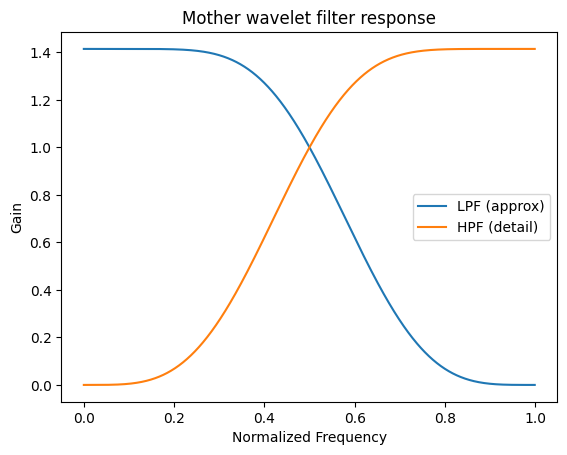

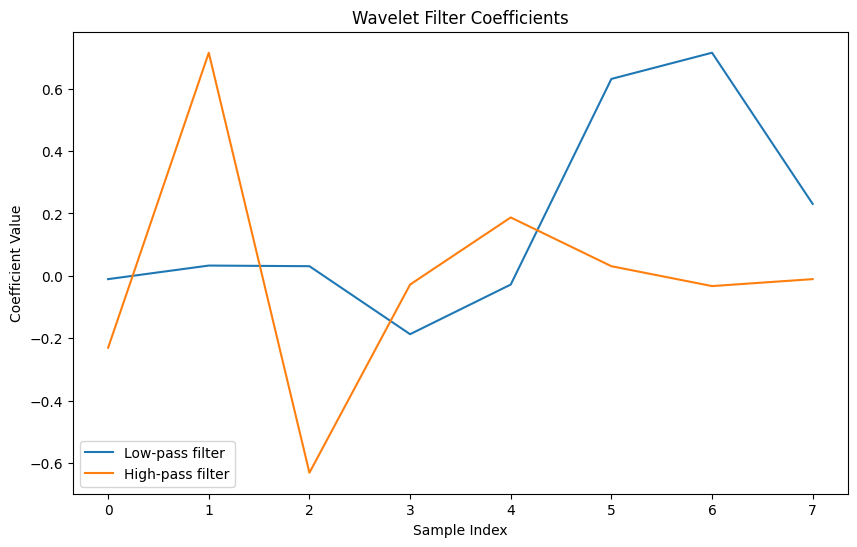

In [41]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

wavelet = pywt.Wavelet('db4')
dec_lo, dec_hi, _, _ = wavelet.filter_bank

# Frequency responses
w_lo, h_lo = freqz(dec_lo, worN=1024)
w_hi, h_hi = freqz(dec_hi, worN=1024)

plt.plot(w_lo / np.pi, abs(h_lo), label="LPF (approx)")
plt.plot(w_hi / np.pi, abs(h_hi), label="HPF (detail)")
plt.xlabel("Normalized Frequency")
plt.ylabel("Gain")
plt.legend()
plt.title("Mother wavelet filter response")
plt.show()


# plot the filter
plt.figure(figsize=(10, 6))
plt.plot(dec_lo, label='Low-pass filter')
plt.plot(dec_hi, label='High-pass filter')
plt.title('Wavelet Filter Coefficients')
plt.xlabel('Sample Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

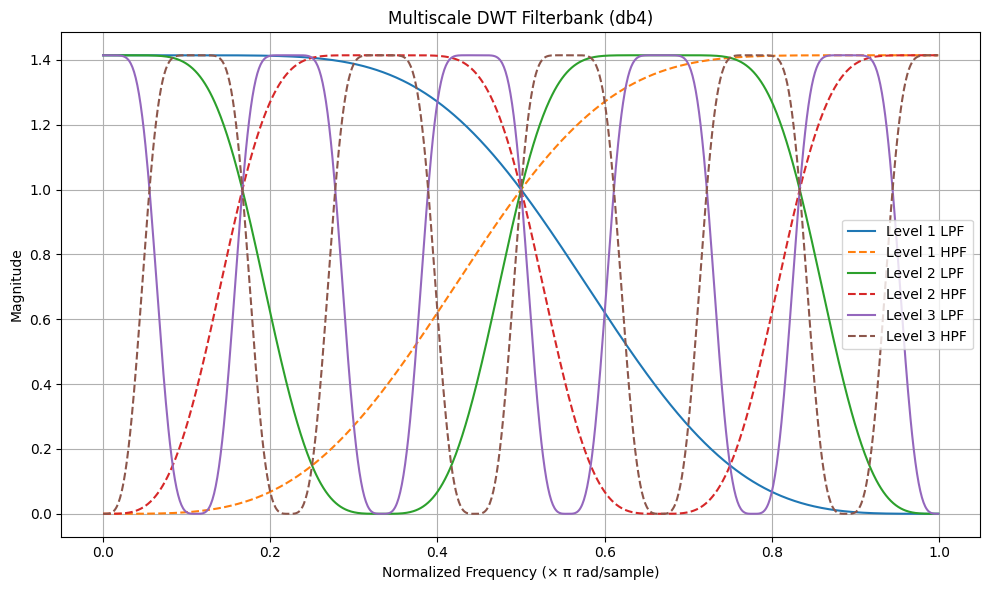

In [1]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Select wavelet and number of levels
wavelet = pywt.Wavelet('db4')
num_levels = 3  # Choose how many decomposition levels you want

# Get the decomposition low-pass and high-pass filter coefficients
dec_lo = wavelet.dec_lo  # Low-pass filter
dec_hi = wavelet.dec_hi  # High-pass filter

# Function to get frequency response for each level
def get_response(h, level):
    # Upsample by inserting 2**(level-1)-1 zeros between each coefficient
    h_up = np.copy(h)
    for _ in range(level - 1):
        h_up = np.insert(h_up, slice(1, None), 0)  # insert 0s between taps
        h_up = np.insert(h_up, slice(2, None, 2), 0)  # adjust for scale
    w, H = freqz(h_up, worN=1024)
    return w, np.abs(H)

# Plot the filter responses
plt.figure(figsize=(10, 6))

for level in range(1, num_levels + 1):
    w_lo, H_lo = get_response(dec_lo, level)
    w_hi, H_hi = get_response(dec_hi, level)

    plt.plot(w_lo / np.pi, H_lo, label=f'Level {level} LPF')
    plt.plot(w_hi / np.pi, H_hi, label=f'Level {level} HPF', linestyle='--')

plt.title('Multiscale DWT Filterbank (db4)')
plt.xlabel('Normalized Frequency (× π rad/sample)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Testing upsampling and downsampling

In [ ]:
from src.utils.sampling import downsample_wavedec

# create a np array of ones with shape [128, 1, 16, 4]
x = np.ones((5, 1, 16, 4))

# change the position of the last two axes
x = np.moveaxis(x, -2, -1)

downsampled = []
for i in range(x.shape[0]):
    batch = []
    for j in range(x.shape[1]):
               batch.append(len(x), downsample_wavedec(x[i][j]), 'db', 1)
    downsampled.append(batch)

print(len(downsampled))
print(len(downsampled[0]))
print(len(downsampled[0][0]))
print(len(downsampled[0][0][3]))




5
1
4
8


In [87]:
set_seed(42)

# Load and shape synthetic test data
x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/test_1"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Shuffle indices once
indices = torch.randperm(len(x))

# Apply the shuffle
x_shuffled = x[indices]
y_shuffled = y[indices]

# create the dataset
dataset = TensorDataset(x_shuffled, y_shuffled)

# create the DataLoader
test_loader = DataLoader(dataset, batch_size=128)


(10000, 1, 16)
(10000,)


In [88]:
samples_0 = []
samples_1 = []

# get one batch
for x, y in test_loader:
    # get the first sequence
    x = x.numpy()
    y = y.numpy()

    for i in range(len(x)):
        if y[i] == 0:
            samples_0.append(x[i][0])
        else:
            samples_1.append(x[i][0])

    break

print(len(samples_0))
print(len(samples_1))

61
67


In [89]:
def plot_fft(signal, fs, ax, label):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax.set_title(f"FFT sample {label}")
    ax.set_xlabel("Frequency (Hz)")


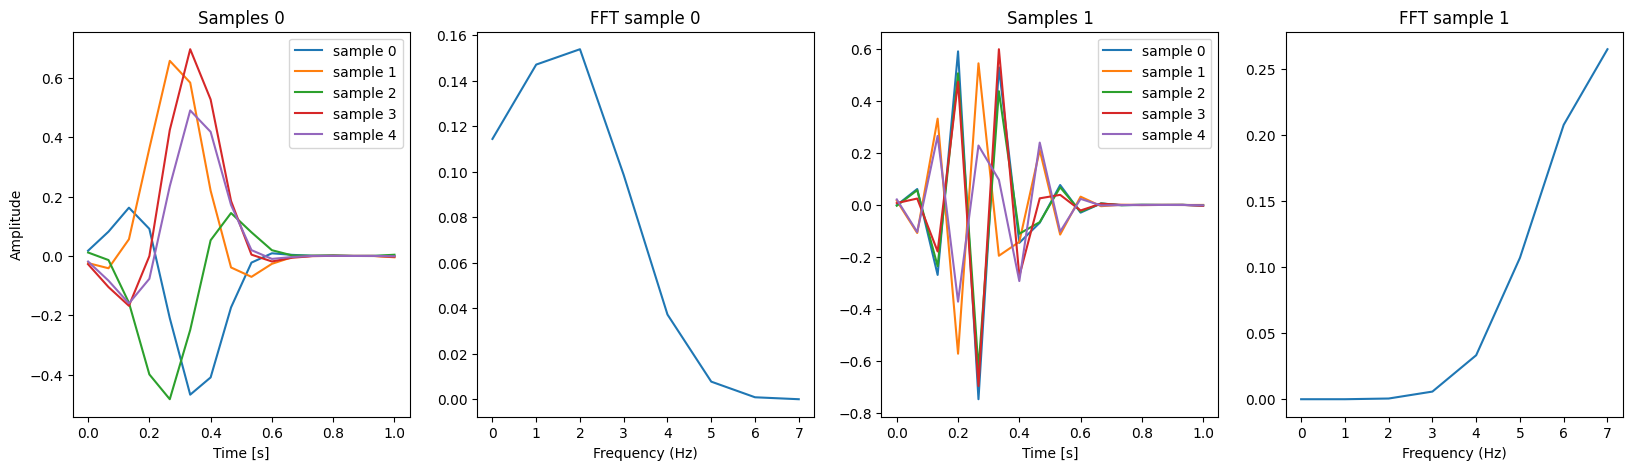

In [90]:
fs = 16
t = np.linspace(0, 1, fs)

# plot 10 samples of samples_0 and samples_1

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i in range(5):
    # plot all the samples in the same figure
    axes[0].plot(t, samples_0[i], label=f"sample {i}")
axes[0].set_title("Samples 0")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Time [s]")
axes[0].legend()

plot_fft(samples_0[0], fs, axes[1], 0)

for i in range(5):
    # plot all the samples in the same figure
    axes[2].plot(t, samples_1[i], label=f"sample {i}")
axes[2].set_title("Samples 1")
axes[2].set_xlabel("Time [s]")
axes[2].legend()

plot_fft(samples_1[0], fs, axes[3], 1)



In [23]:
# compute max level dwt
import pywt

# Compute the maximum level of DWT for a given signal length and wavelet
max_level = pywt.dwt_max_level(100, 'db1')
print(f'Haar: {max_level}')
max_level = pywt.dwt_max_level(100, 'db2')
print(f'Daubechies 2: {max_level}')
max_level = pywt.dwt_max_level(100, 'db3')
print(f'Daubechies 3: {max_level}')
max_level = pywt.dwt_max_level(100, 'db4')
print(f'Daubechies 4: {max_level}')
max_level = pywt.dwt_max_level(100, 'sym2')
print(f'Symlet 2: {max_level}')
max_level = pywt.dwt_max_level(100, 'sym3')
print(f'Symlet 3: {max_level}')
max_level = pywt.dwt_max_level(100, 'sym4')
print(f'Symlet 4: {max_level}')
max_level = pywt.dwt_max_level(100, 'coif1')
print(f'Coiflet 1: {max_level}')
max_level = pywt.dwt_max_level(100, 'coif2')
print(f'Coiflet 2: {max_level}')
max_level = pywt.dwt_max_level(100, 'coif3')
print(f'Coiflet 3: {max_level}')



Haar: 6
Daubechies 2: 5
Daubechies 3: 4
Daubechies 4: 3
Symlet 2: 5
Symlet 3: 4
Symlet 4: 3
Coiflet 1: 4
Coiflet 2: 3
Coiflet 3: 2


In [24]:
# split a string into alphabetical and numerical parts
import re
def split_string(s):
    # Use regex to find all sequences of digits and non-digits
    parts = re.findall(r'\d+|[^\d\s]+', s)
    return parts

In [25]:
dwts =  ['db1', 'db2', 'db3', 'db4', 'sym2', 'sym3', 'sym4', 'coif1', 'coif2', 'coif3']

for dwt in dwts:
    print(f"{dwt}: {split_string(dwt)}")

db1: ['db', '1']
db2: ['db', '2']
db3: ['db', '3']
db4: ['db', '4']
sym2: ['sym', '2']
sym3: ['sym', '3']
sym4: ['sym', '4']
coif1: ['coif', '1']
coif2: ['coif', '2']
coif3: ['coif', '3']


In [48]:
# compute themultilevel dwt
coeffs_0 = {}
coeffs_1 = {}

for w in dwts:
    coeffs_0[w] = pywt.wavedec(samples_0[0], wavelet=w)
    coeffs_1[w] = pywt.wavedec(samples_1[0], wavelet=w)

    print(f"Wavelet: {w}")
    print(f"num levels: {len(coeffs_0[w])}")


Wavelet: db1
num levels: 5
Wavelet: db2
num levels: 3
Wavelet: db3
num levels: 2
Wavelet: db4
num levels: 2
Wavelet: sym2
num levels: 3
Wavelet: sym3
num levels: 2
Wavelet: sym4
num levels: 2
Wavelet: coif1
num levels: 2
Wavelet: coif2
num levels: 1
Wavelet: coif3
num levels: 1


In [49]:
coeffs_0 = []
coeffs_1 = []

for i in range(10):
    coeffs_0.append(pywt.wavedec(samples_0[i], wavelet='db1'))
    coeffs_1.append(pywt.wavedec(samples_1[i], wavelet='db1'))

print(len(coeffs_0))
print(len(coeffs_1))

10
10


In [45]:
# plot scaleograms
import math

def plot_dwt_scaleogram(coeffs, w, fs=100, normalized=False):
    """
    coeffs: list of coefficients
    fs: sampling frequency
    """
    # Create a figure
    plt.figure(figsize=(10, 6))

    # compute the frequency bands
    freq_bands = [fs / (2 ** (j + 1)) for j in range(len(coeffs))]   # bands
    freq_bands.append(0)                                             # lowest frequency
    freq_bands = freq_bands[::-1]                                    # reverse the order

    upsampling = []
    # upsample the coefficients to match the original signal length
    for i, coeff in enumerate(coeffs):
        factor = math.ceil(fs / len(coeff))
        coeff_upsampled = np.repeat(coeff, factor)[:fs]

        upsampling.append(coeff_upsampled)

    
    scaleogram = np.array(upsampling)
    # scaleogram = scaleogram[:, :]
    scaleogram = np.abs(scaleogram)
    
    # normalize the scaleogram
    if normalized:
        scaleogram = (scaleogram - np.min(scaleogram)) / (np.max(scaleogram) - np.min(scaleogram) + 1e-10)

    # Create a meshgrid for time and frequency
    time = np.linspace(0, 1, fs)
    time = np.concatenate([time, [time[-1] + (1/fs)]])

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(time, freq_bands, scaleogram, shading='auto', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title(f'Scaleogram of {w} wavelet {normalized}')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()

In [106]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

def plot_wavelet_filters(wavelet_name, figsize=(12, 8), plot_frequency_response=False):
    """
    Plot the wavelet filters (low-pass and high-pass) for a given wavelet.
    
    Parameters:
    -----------
    wavelet_name : str
        Name of the wavelet to plot (e.g., 'db4', 'haar', 'sym4')
    figsize : tuple, optional
        Figure size (width, height) in inches
    plot_frequency_response : bool, optional
        Whether to plot the frequency response of the filters
    """
    # Get the wavelet object
    wavelet = pywt.Wavelet(wavelet_name)
    
    # Create figure and subplots
    if plot_frequency_response:
        fig, axes = plt.subplots(2, 2, figsize=figsize)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Get the filters
    low_pass = wavelet.dec_lo
    high_pass = wavelet.dec_hi
    
    # Plot low-pass filter
    if plot_frequency_response:
        axes[0, 0].plot(low_pass)
        axes[0, 0].set_title('Low-pass Filter (Scaling Function)')
        axes[0, 0].grid(True)
        axes[0, 0].set_xlabel('Sample Index')
        axes[0, 0].set_ylabel('Amplitude')
    else:
        axes[0].plot(low_pass)
        axes[0].set_title('Low-pass Filter (Scaling Function)')
        axes[0].grid(True)
        axes[0].set_xlabel('Sample Index')
        axes[0].set_ylabel('Amplitude')
    
    # Plot high-pass filter
    if plot_frequency_response:
        axes[0, 1].plot(high_pass)
        axes[0, 1].set_title('High-pass Filter (Wavelet Function)')
        axes[0, 1].grid(True)
        axes[0, 1].set_xlabel('Sample Index')
        axes[0, 1].set_ylabel('Amplitude')
    else:
        axes[1].plot(high_pass)
        axes[1].set_title('High-pass Filter (Wavelet Function)')
        axes[1].grid(True)
        axes[1].set_xlabel('Sample Index')
        axes[1].set_ylabel('Amplitude')
    
    if plot_frequency_response:
        # Compute frequency response
        N = len(low_pass)
        freq = np.fft.fftfreq(N)
        
        # Plot frequency response of low-pass filter
        axes[1, 0].plot(freq, np.abs(np.fft.fft(low_pass)) / N)
        axes[1, 0].set_title('Frequency Response - Low-pass')
        axes[1, 0].grid(True)
        axes[1, 0].set_xlabel('Normalized Frequency')
        axes[1, 0].set_ylabel('Magnitude')
        axes[1, 0].set_xlim(-0.5, 0.5)
        
        # Plot frequency response of high-pass filter
        axes[1, 1].plot(freq, np.abs(np.fft.fft(high_pass)) / N)
        axes[1, 1].set_title('Frequency Response - High-pass')
        axes[1, 1].grid(True)
        axes[1, 1].set_xlabel('Normalized Frequency')
        axes[1, 1].set_ylabel('Magnitude')
        axes[1, 1].set_xlim(-0.5, 0.5)
    
    # Add main title
    plt.suptitle(f'Wavelet Filters for {wavelet_name} Wavelet', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return fig, axes


(<Figure size 1200x800 with 4 Axes>,
 array([[<Axes: title={'center': 'Low-pass Filter (Scaling Function)'}, xlabel='Sample Index', ylabel='Amplitude'>,
         <Axes: title={'center': 'High-pass Filter (Wavelet Function)'}, xlabel='Sample Index', ylabel='Amplitude'>],
        [<Axes: title={'center': 'Frequency Response - Low-pass'}, xlabel='Normalized Frequency', ylabel='Magnitude'>,
         <Axes: title={'center': 'Frequency Response - High-pass'}, xlabel='Normalized Frequency', ylabel='Magnitude'>]],
       dtype=object))

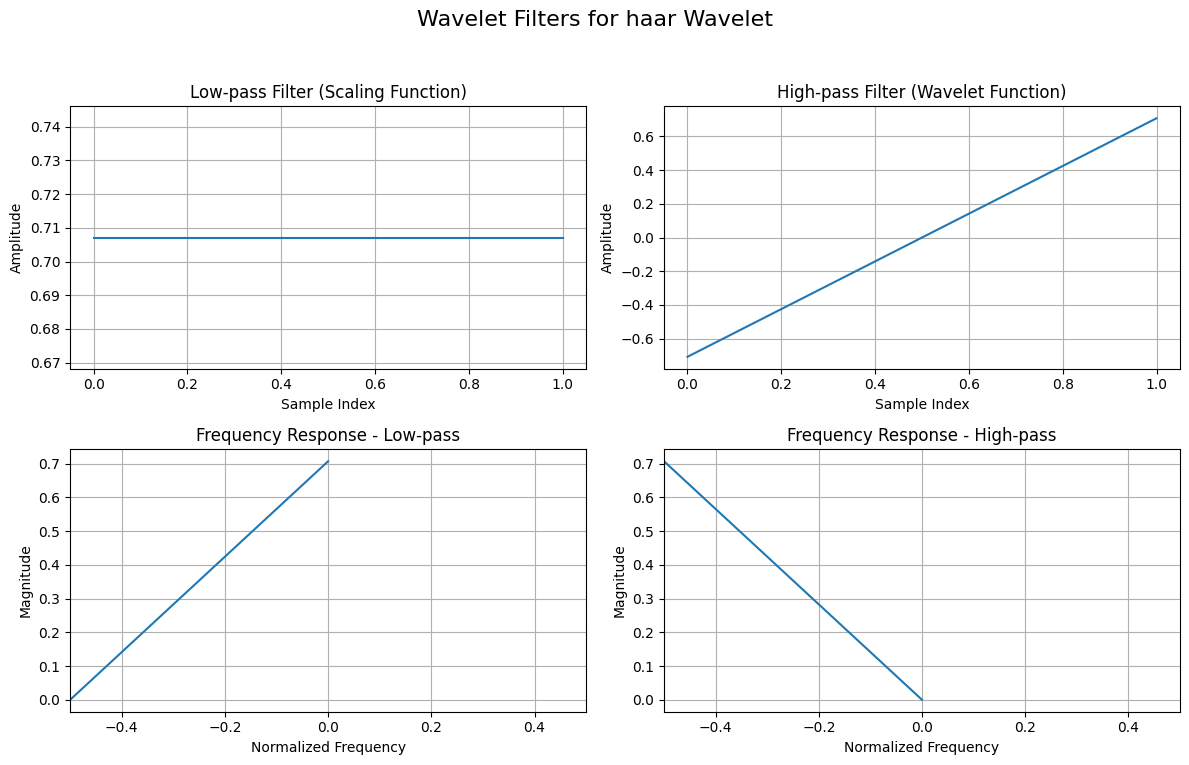

In [108]:
# Plot filters for the Haar wavelet
plot_wavelet_filters('haar', plot_frequency_response=True)

# # Plot filters for Daubechies 4 wavelet with 3 levels
# plot_wavelet_filters('db4', plot_frequency_response=True)

# # Plot filters for Symmlet 4 wavelet with custom figure size
# plot_wavelet_filters('sym4', figsize=(15, 10), plot_frequency_response=True)

In [113]:
def plot_wavelet_filters(family, vanishing_moments):
    """
    Plots the four filters associated with a given wavelet family and order.

    Args:
        family (str): The wavelet family name (e.g., 'db', 'sym', 'coif').
        vanishing_moments (int): The number of vanishing moments (the 'N' in dbN).
    """
    # Construct the full wavelet name (e.g., 'db4')
    wavelet_name = f"{family}{vanishing_moments}"

    # --- 1. Get the Wavelet Object and Filters ---
    try:
        wavelet = pywt.Wavelet(wavelet_name)
    except ValueError:
        print(f"Error: The wavelet '{wavelet_name}' does not exist in PyWavelets.")
        print("Please check the family name and number of vanishing moments.")
        # For example, 'sym1' does not exist, starts at 'sym2'.
        # 'coif' N must be between 1 and 5.
        return

    # Extract the four filters
    # These are the raw filter coefficients (impulse response)
    dec_lo = wavelet.dec_lo  # Decomposition Low-pass
    dec_hi = wavelet.dec_hi  # Decomposition High-pass
    rec_lo = wavelet.rec_lo  # Reconstruction Low-pass
    rec_hi = wavelet.rec_hi  # Reconstruction High-pass

    filters = {
        'Decomposition Low-pass (Analysis)': dec_lo,
        'Decomposition High-pass (Analysis)': dec_hi,
        # 'Reconstruction Low-pass (Synthesis)': rec_lo,
        # 'Reconstruction High-pass (Synthesis)': rec_hi
    }
    
    # --- 2. Create the Plot ---
    fig, axs = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)
    fig.suptitle(f"Filters for {wavelet.name.capitalize()} Wavelet (N={vanishing_moments})", fontsize=18)
    
    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    for i, (title, coeffs) in enumerate(filters.items()):
        ax = axs[i]
        
        # Create an x-axis for the coefficients
        x_axis = np.arange(len(coeffs))
        
        # Plot using a stem plot for discrete coefficients
        markerline, stemlines, baseline = ax.stem(
            x_axis, coeffs, basefmt='gray'
        )
        plt.setp(stemlines, 'linewidth', 2)
        plt.setp(markerline, 'markersize', 6)
        
        # Add a connecting line to guide the eye
        ax.plot(x_axis, coeffs, 'c--', alpha=0.5)

        # Formatting
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Coefficient Index")
        ax.set_ylabel("Value")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.axhline(0, color='black', linewidth=0.7)
        ax.set_xticks(x_axis) # Ensure all integer indices are shown

    plt.show()

Plotting filters for Daubechies db4...


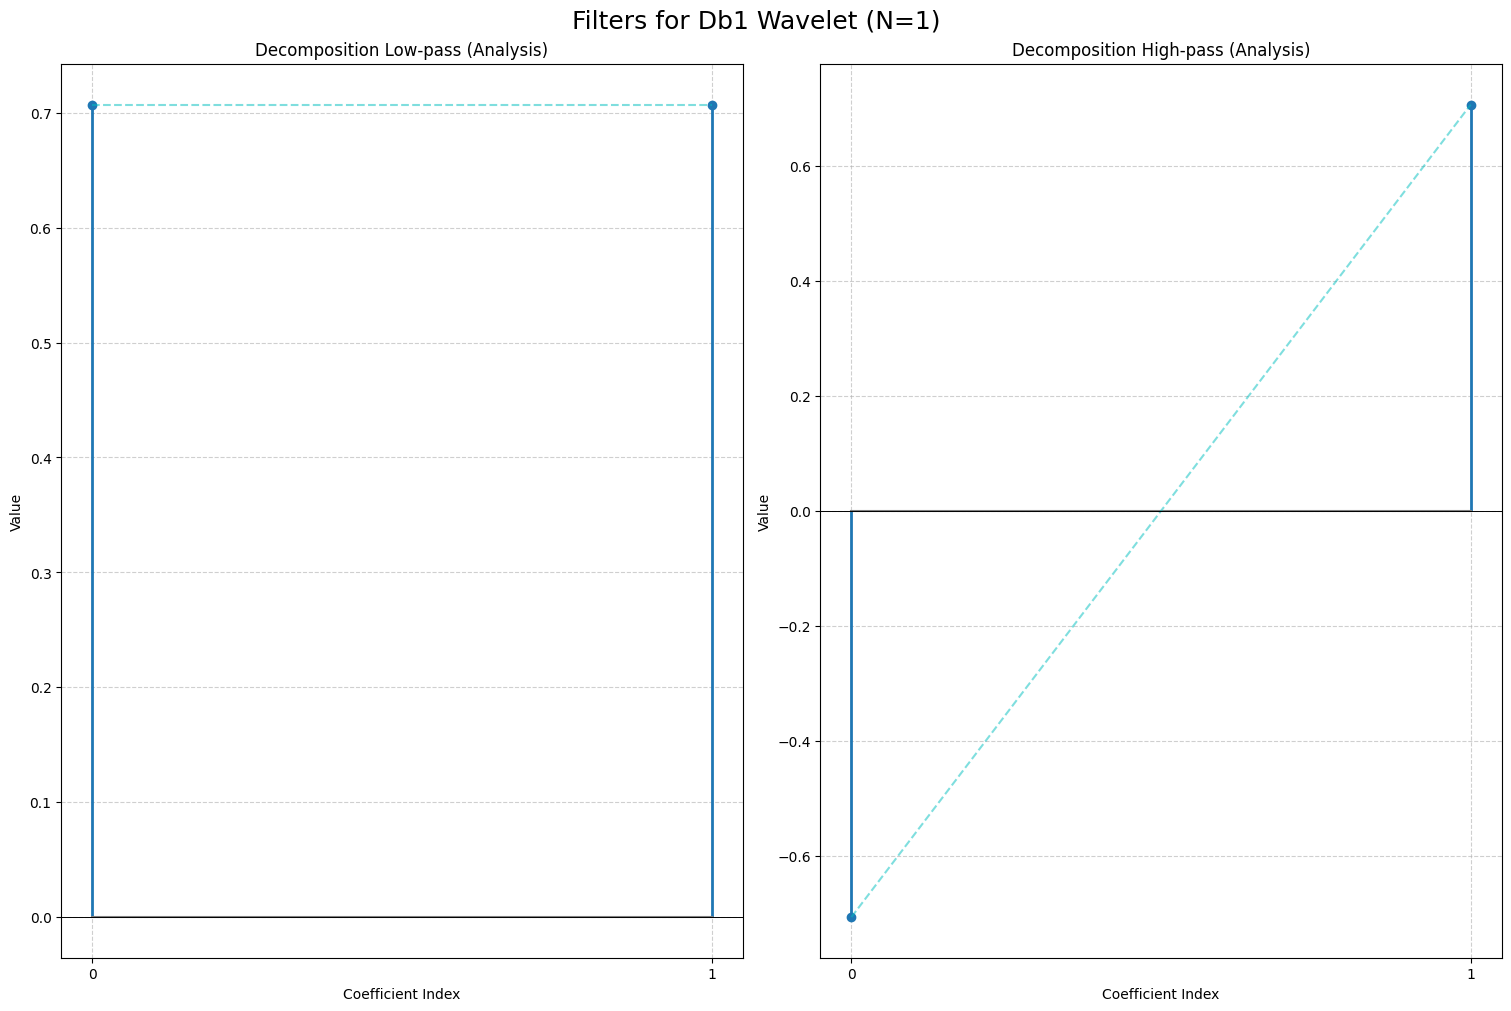

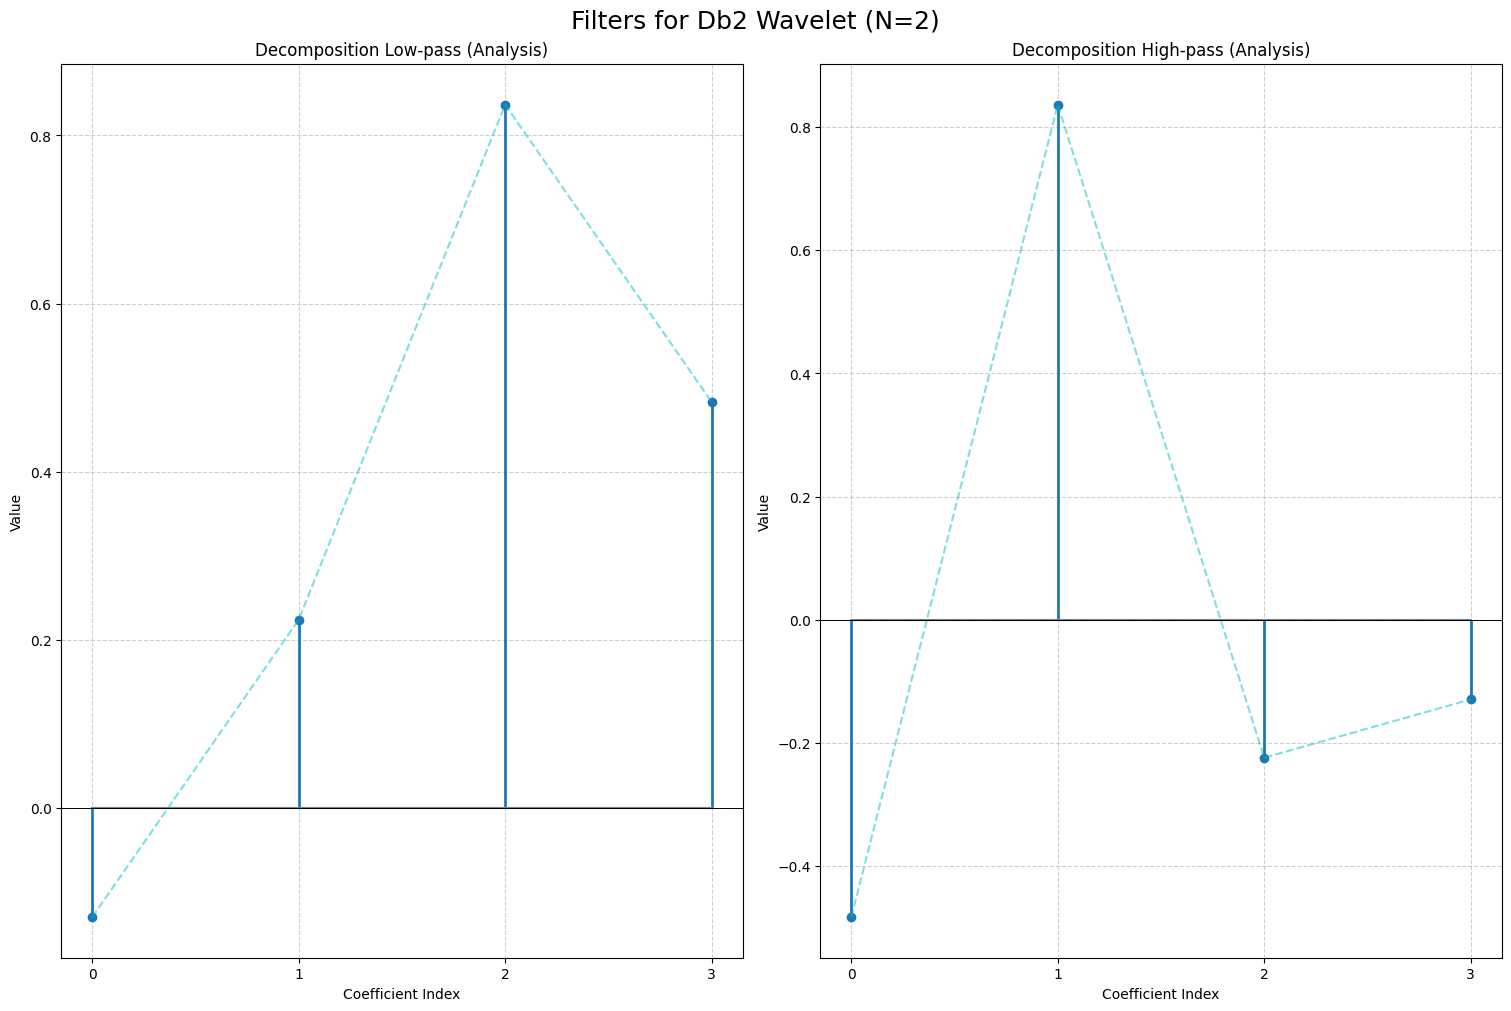

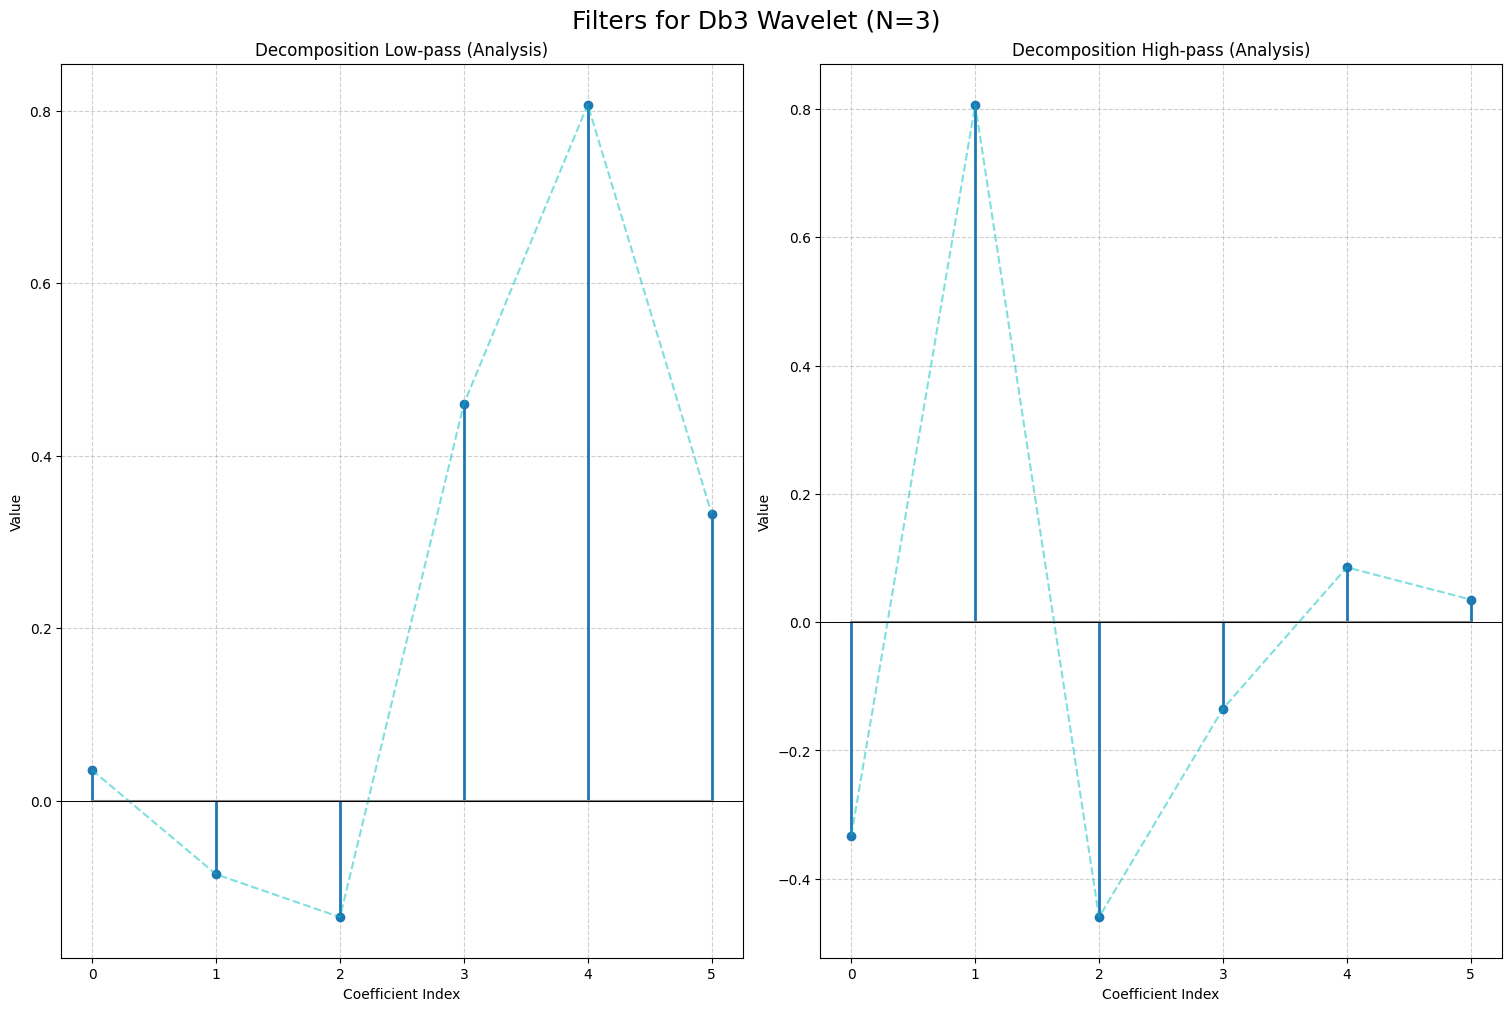

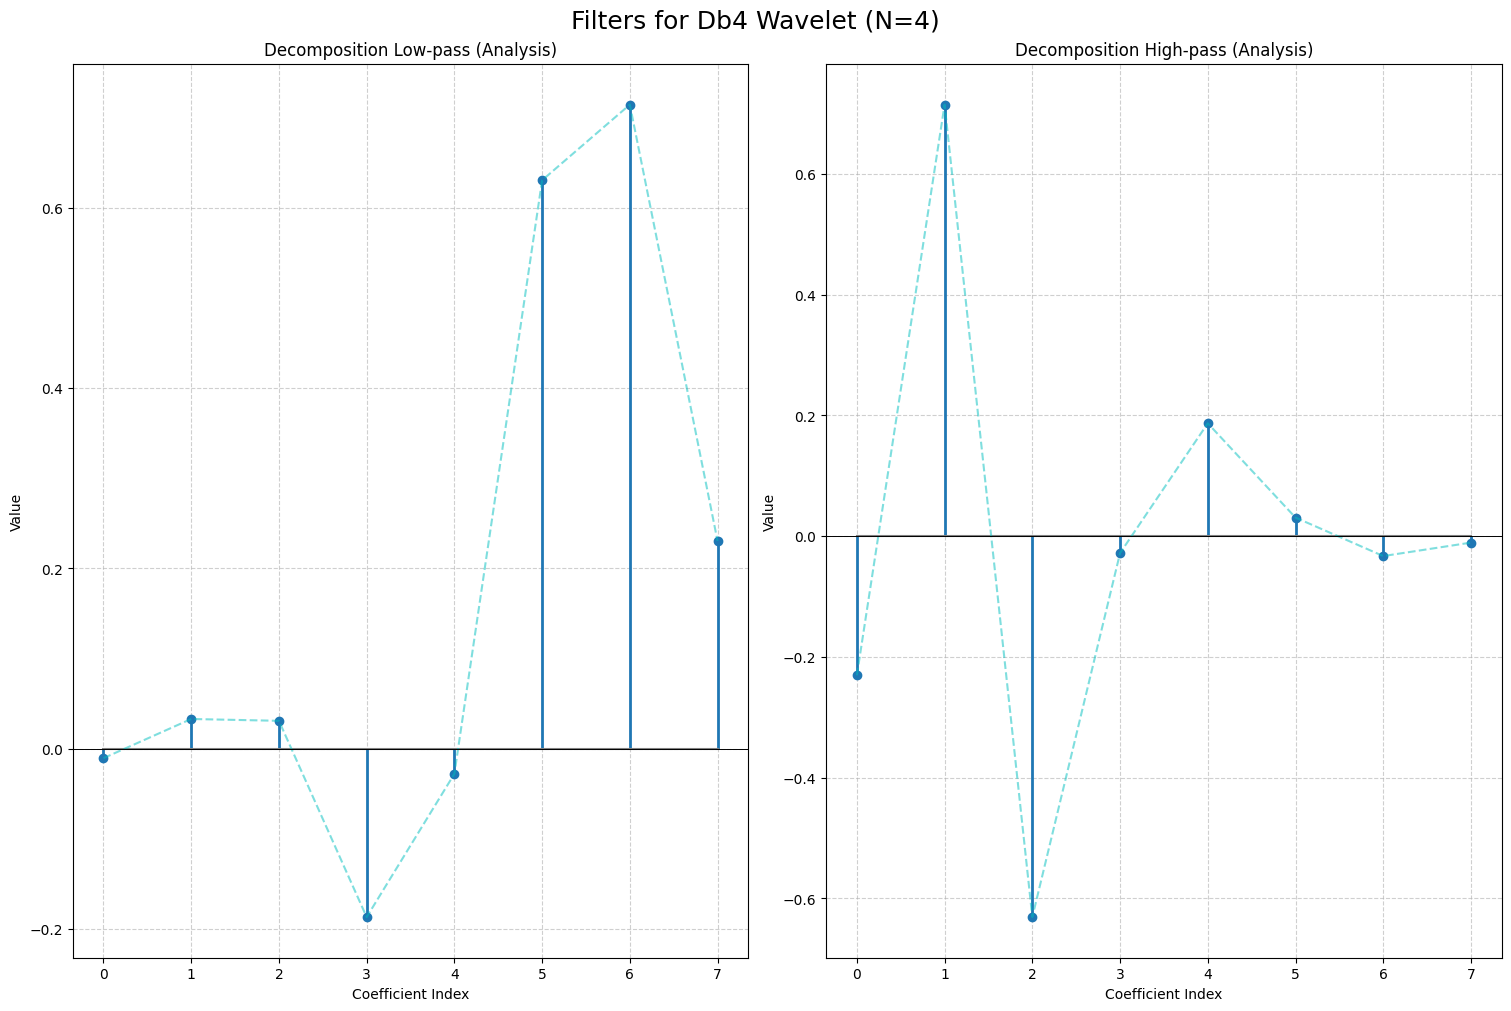

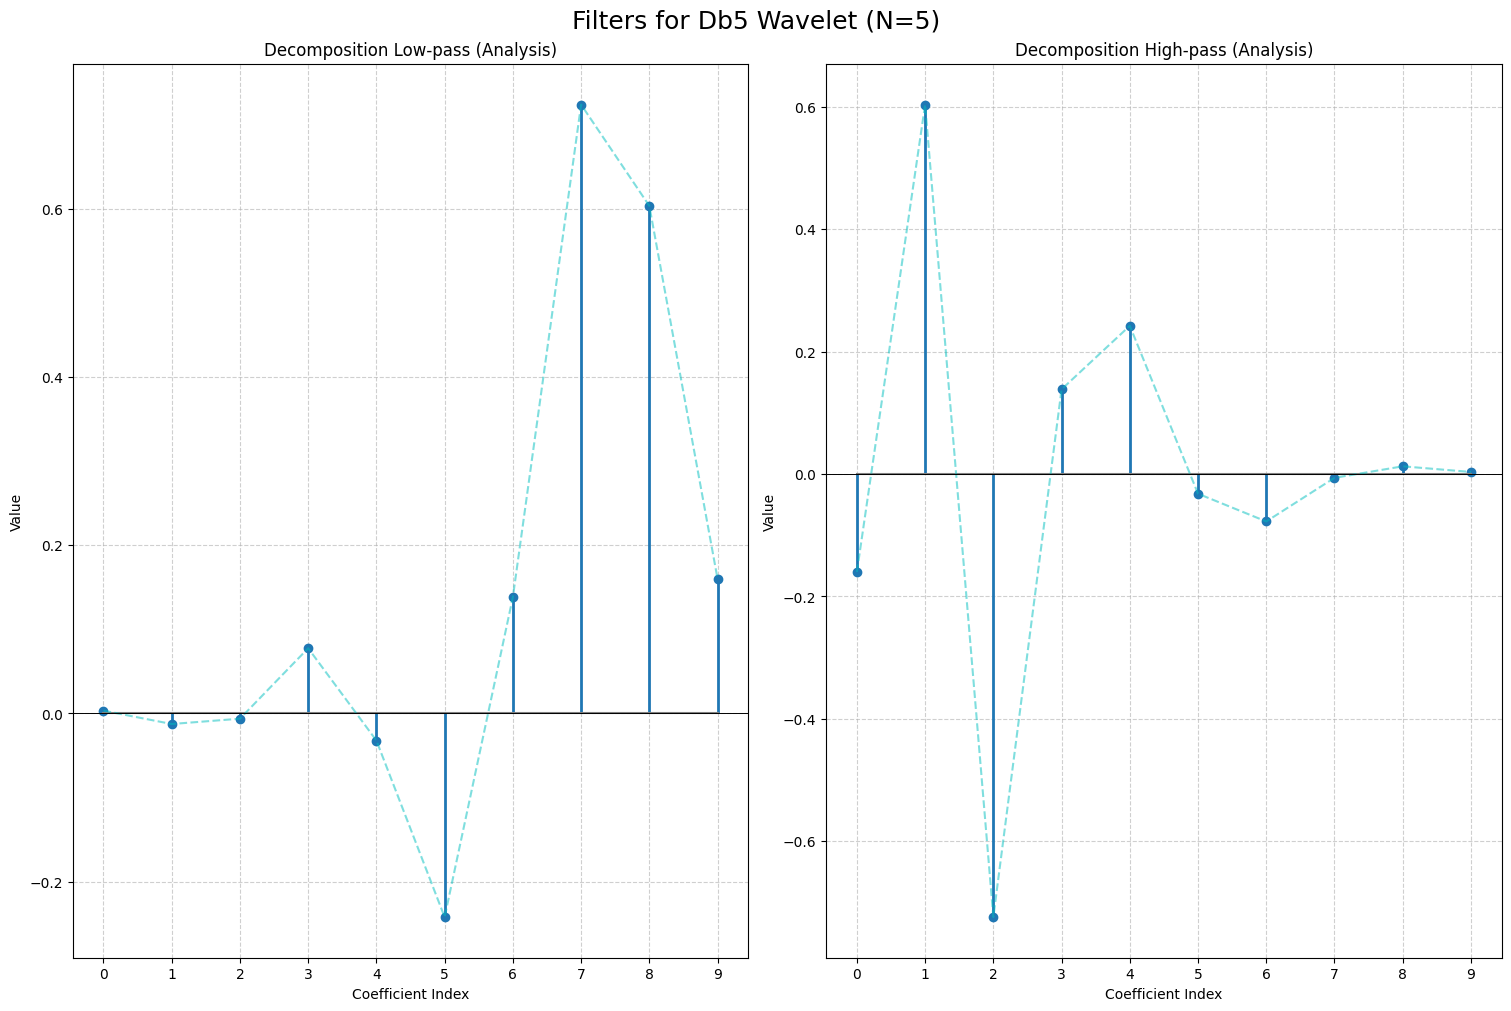

In [114]:
# Example 1: Plot the filters for the Daubechies 'db4' wavelet
print("Plotting filters for Daubechies db4...")
plot_wavelet_filters('db', 1)
plot_wavelet_filters('db', 2)
plot_wavelet_filters('db', 3)
plot_wavelet_filters('db', 4)
plot_wavelet_filters('db', 5)


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from torch._awaits import W

def plot_wavelet_spectra_positive(wavelet_name, order = None):
    """
    Computes and plots the POSITIVE frequency spectra of the scaling (phi) 
    and wavelet (psi) functions for a given wavelet.

    Args:
        wavelet_name (str): The name of the wavelet (e.g., 'db4', 'sym8', 'coif5').
    """

    if order == None:
        order = [1, 2, 3, 4]

    fig, axs = plt.subplots(1, len(order), figsize=(14, 4), constrained_layout=True)

    for i, o in enumerate(order):
        w = f"{wavelet_name}{o}"

        try:
            wavelet = pywt.Wavelet(w)
        except ValueError:
            print(f"Error: Wavelet '{w}' not found.")
            return

        # Use a high level for a high-resolution function
        phi, psi, x = wavelet.wavefun()
        
        n_points = len(x)
        dt = x[1] - x[0]
        
        phi_fft = np.fft.fft(phi)
        psi_fft = np.fft.fft(psi)
        
        # The full frequency axis from fftfreq
        full_freq_axis = np.fft.fftfreq(n_points, d=dt)
        
        # We only need the first half of the arrays for the positive frequencies
        num_positive_freqs = n_points // 2
        
        positive_freq_axis = full_freq_axis[:num_positive_freqs]
        
        # Take the absolute value of the FFT output and slice it
        phi_magnitude = np.abs(phi_fft)[:num_positive_freqs]
        psi_magnitude = np.abs(psi_fft)[:num_positive_freqs]

        # normalize the magnitudes with a min max scale between them
        max_val = np.max(np.concatenate([phi_magnitude, psi_magnitude]))
        phi_magnitude = phi_magnitude / max_val
        psi_magnitude = psi_magnitude / max_val

        # fig.suptitle(f"Positive Frequency Spectra for '{w}' Wavelet", fontsize=18)

        # Plot Scaling Function Spectrum
        axs[i].plot(positive_freq_axis, psi_magnitude, label='psi')
        axs[i].plot(positive_freq_axis, phi_magnitude, label='phi')
        axs[i].set_title(w)
        # axs[i].set_xlabel("Frequency")
        axs[i].legend()
        axs[i].set_xlim(left=0, right=5) # Set x-axis to start at 0
        axs[i].set_ylim(bottom=0)

        if i == 0:
            axs[i].set_ylabel("Amplitude")

    
    plt.show()

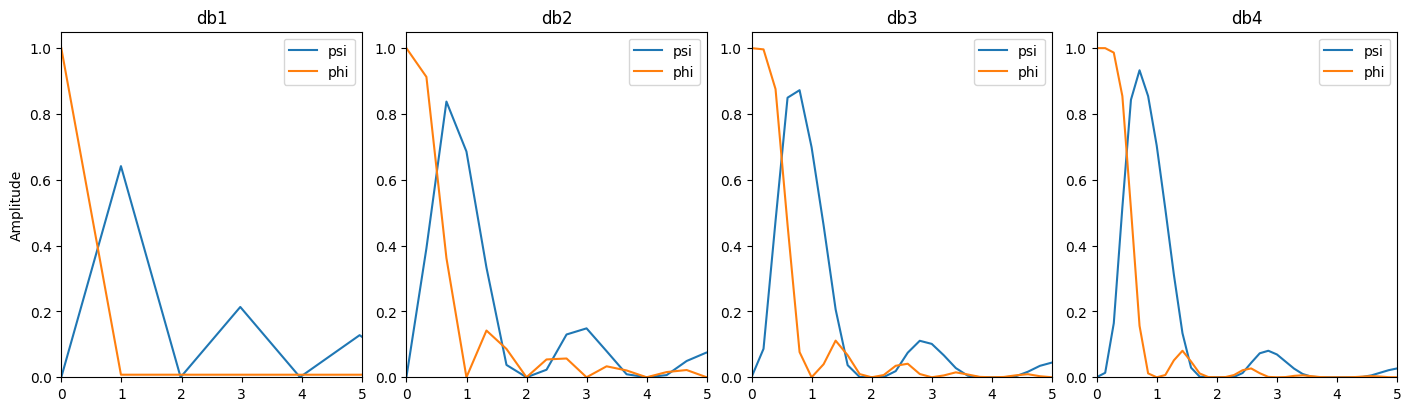

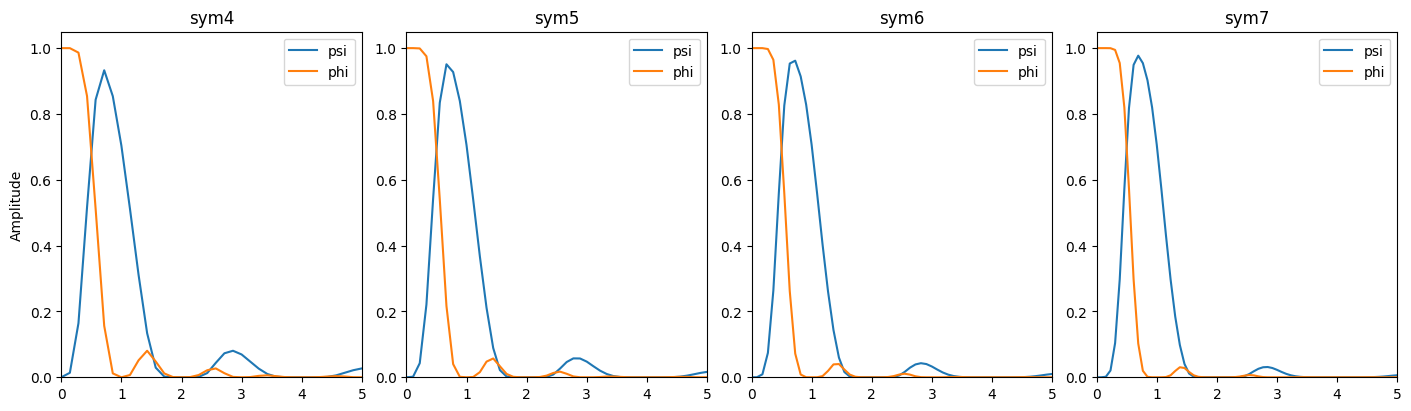

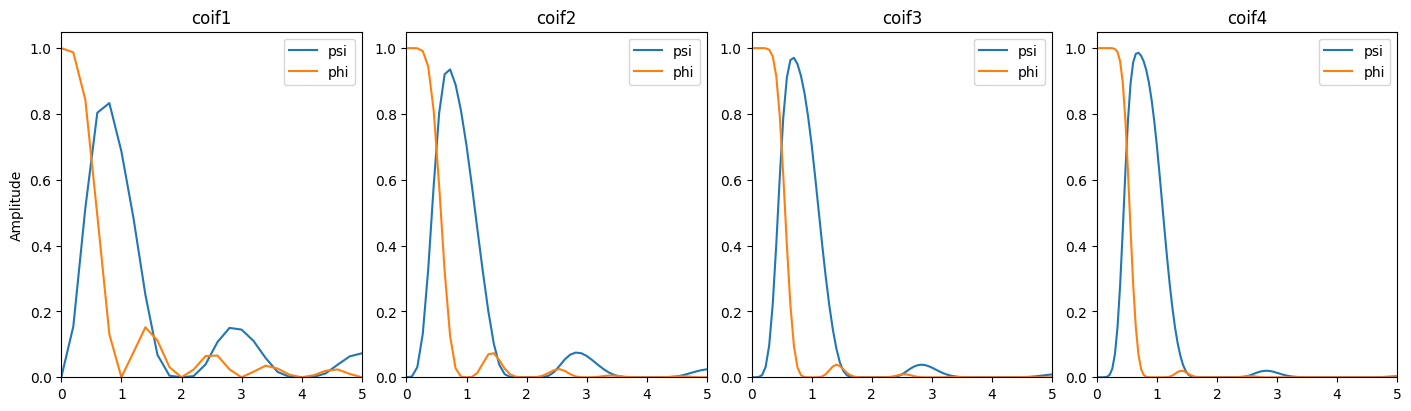

In [180]:
plot_wavelet_spectra_positive('db', [1, 2, 3, 4])
plot_wavelet_spectra_positive('sym', [4, 5, 6, 7])
plot_wavelet_spectra_positive('coif', [1, 2, 3, 4])
